In [3]:

# monitor training performance
from numpy import loadtxt
from numpy import genfromtxt
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt


In [4]:
from matplotlib import pyplot

In [2]:
from sklearn.model_selection import GridSearchCV

In [5]:
import sklearn.metrics 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [6]:

import tensorflow as tf

In [7]:
def score(m, x_train, y_train, x_val, y_val, train=True):
    if train:
        pred=m.predict(x_train)
        print('Train Result:\n')
        print(f"Accuracy Score: {accuracy_score(y_train, pred)*100:.2f}%")
        print(f"Precision Score: {precision_score(y_train, pred)*100:.2f}%")
        print(f"Recall Score: {recall_score(y_train, pred)*100:.2f}%")
        print(f"F1 score: {f1_score(y_train, pred)*100:.2f}%")
        print(f"Confusion Matrix:\n {confusion_matrix(y_train, pred)}")
    elif train == False:
        pred=m.predict(x_val)
        print('Test Result:\n')
        print(f"Accuracy Score: {accuracy_score(y_val, pred)*100:.2f}%")
        print(f"Precision Score: {precision_score(y_val, pred)*100:.2f}%")
        print(f"Recall Score: {recall_score(y_val, pred)*100:.2f}%")
        print(f"F1 score: {f1_score(y_val, pred)*100:.2f}%")
        print(f"Confusion Matrix:\n {confusion_matrix(y_val, pred)}")

In [104]:
dataset = pd.read_csv(r"..\NEW_DRUGS_boruta.csv")

dataset = dataset.drop(['cathinone'],axis=1)
dataset = dataset.drop(['k1'],axis=1)
dataset = dataset.drop(['ketamineclass'],axis=1)
dataset = dataset.drop(['phenethylamines'],axis=1)
dataset = dataset.drop(['tryptamines'],axis=1)
dataset = dataset.drop(['piperazine'],axis=1)
dataset = dataset.drop(['bzd'],axis=1)
dataset = dataset.drop(['typeopium'],axis=1)
dataset = dataset.drop(['traditiondrugabuse'],axis=1)

Y = dataset.iloc[:, 0].values
X = dataset.iloc[:, 1:].values

X_trainval, X_test, y_trainval, y_test = train_test_split(X, Y, test_size=0.2, random_state=44, stratify=Y,shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=44, stratify=y_trainval,shuffle=True)

SMOTE

In [105]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=2022,sampling_strategy=0.3)
X_train_smote, y_train_smote = smote.fit_resample(X_trainval, y_trainval)

print(pd.Series(y_train_smote).value_counts())

0    864
1    259
dtype: int64


XGB_SMOTE

最佳AUC: 0.8286568388199893，最佳參數組合：{'booster': 'dart', 'eta': 0.1, 'gamma': 5, 'learning_rate': 0.1, 'max_delta_step': 0.8, 'max_depth': 7, 'min_child_weight': 7, 'normalize_type': 'tree', 'objective': 'binary:logistic', 'rate_drop': 0.3, 'sample_type': 'uniform', 'skip_drop': 0.5, 'subsample': 0.8}
訓練集平均AUC: 0.8975896091762667, 標準差: 0.01436687032783598, 驗證集平均AUC: 0.8286568388199893, 標準差: 0.06246274802442253, 參數組合: {'booster': 'dart', 'eta': 0.1, 'gamma': 5, 'learning_rate': 0.1, 'max_delta_step': 0.8, 'max_depth': 7, 'min_child_weight': 7, 'normalize_type': 'tree', 'objective': 'binary:logistic', 'rate_drop': 0.3, 'sample_type': 'uniform', 'skip_drop': 0.5, 'subsample': 0.8}


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


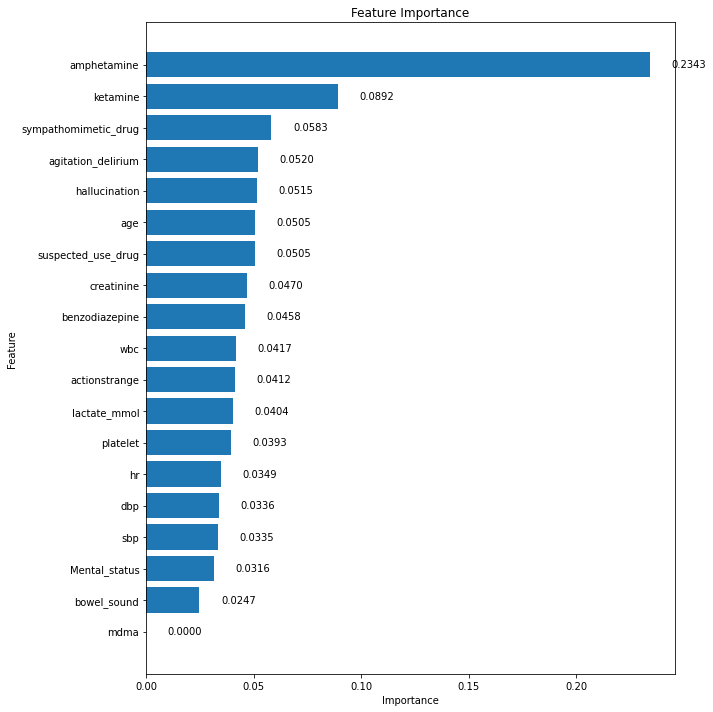

In [106]:
params = {'booster': ['dart'], 
          'max_depth': [7], 
          'learning_rate': [0.1], 
          'objective': ['binary:logistic'], 
          'sample_type': ['uniform'], 
          'normalize_type': ['tree'], 
          'rate_drop': [0.3], 
          'skip_drop': [0.5],
          'eta' : [0.1],
          'gamma': [5],
          'min_child_weight': [7],
          'max_delta_step': [0.8],
          'subsample': [0.8]
        }

xg =  XGBClassifier()
grid = GridSearchCV(xg, params, cv=5,verbose=False,scoring = 'roc_auc',return_train_score=True)
grid.fit(X_train_smote, y_train_smote)
best_params = grid.best_params_

# 評估，打分數
print(f"最佳AUC: {grid.best_score_}，最佳參數組合：{grid.best_params_}")
# 取得 cross validation 的平均準確率及標準差

means_train = grid.cv_results_['mean_train_score']
stds_train = grid.cv_results_['std_train_score']
means_val = grid.cv_results_['mean_test_score']
stds_val = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean_train, stdev_train, mean_val, stdev_val, param in zip(means_train, stds_train, means_val, stds_val, params):
    print(f"訓練集平均AUC: {mean_train}, 標準差: {stdev_train}, 驗證集平均AUC: {mean_val}, 標準差: {stdev_val}, 參數組合: {param}")


model = XGBClassifier(**best_params)


eval_set = [(X_train_smote, y_train_smote)]

model.fit(X_train_smote, y_train_smote, early_stopping_rounds=10, eval_metric='auc', eval_set=eval_set, verbose=False) #auc

y_pred = model.predict(X_val)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_val, predictions)

# 轉換X為DataFrame物件
l = pd.DataFrame(X, columns=dataset.columns[1:])

# 取得特徵重要性
importance = model.feature_importances_

# 建立特徵重要性的資料框
feature_importances = pd.DataFrame({'Feature': l.columns, 'Importance': importance})
feature_importances = feature_importances.sort_values('Importance', ascending=False).reset_index(drop=True)

# 設定圖表大小
plt.figure(figsize=(10, 10))

# 繪製特徵重要性長條圖
plt.barh(feature_importances['Feature'], feature_importances['Importance'], align='center')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')

# 反轉Y軸，讓重要性高的項目顯示在上方
plt.gca().invert_yaxis()

# 顯示特徵重要性數值
for i, v in enumerate(feature_importances['Importance']):
    plt.text(v + 0.01, i, f'{v:.4f}', color='black', va='center')

# 調整Y軸刻度標籤
plt.yticks(range(len(feature_importances['Feature'])), feature_importances['Feature'])

plt.tight_layout()
plt.show()

y_pred_proba_train = model.predict_proba(X_train_smote)
fpr_train, tpr_train, _ = sklearn.metrics.roc_curve(y_train_smote, y_pred_proba_train[:, 1])
y_pred_proba_test = model.predict_proba(X_test)
auc_train = sklearn.metrics.auc(fpr_train, tpr_train)
fpr_test_final, tpr_test_final, _ = sklearn.metrics.roc_curve(y_test, y_pred_proba_test[:, 1])


# 使用模型進行預測
y_pred = model.predict(X_test)

auc_test_final = sklearn.metrics.auc(fpr_test_final, tpr_test_final)
xgb_auc = fpr_test_final,tpr_test_final,auc_test_final,f1_score(y_test, y_pred)*100 #組合用


In [19]:
best_params
# 評估，打分數
print(f"最佳AUC: {grid.best_score_}，最佳參數組合：{grid.best_params_}")

最佳AUC: 0.8303929818227973，最佳參數組合：{'booster': 'dart', 'eta': 0.1, 'gamma': 5, 'learning_rate': 0.1, 'max_delta_step': 0.8, 'max_depth': 7, 'min_child_weight': 6, 'normalize_type': 'tree', 'objective': 'binary:logistic', 'rate_drop': 0.3, 'sample_type': 'uniform', 'skip_drop': 0.5, 'subsample': 0.8}


D:\kfcteam-cy\Anaconda3\envs\pangolin\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Accuracy: 0.8444444444444444


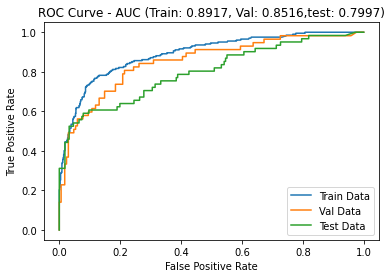

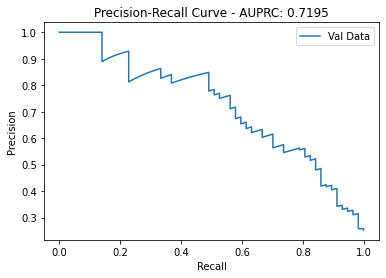

Val Result:

Accuracy Score: 84.44%
Precision Score: 84.38%
Recall Score: 47.37%
F1 score: 60.67%
Confusion Matrix:
[[163   5]
 [ 30  27]]
AUPRC: 0.7195
test Result:

Accuracy Score: 86.28%
Precision Score: 87.10%
Recall Score: 44.26%
F1 score: 58.70%
Confusion Matrix:
[[212   4]
 [ 34  27]]


D:\kfcteam-cy\Anaconda3\envs\pangolin\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Accuracy: 0.8533333333333334


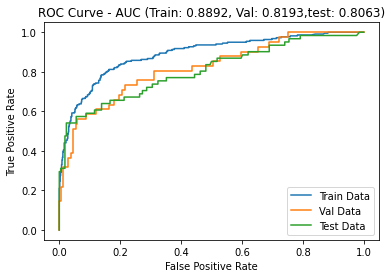

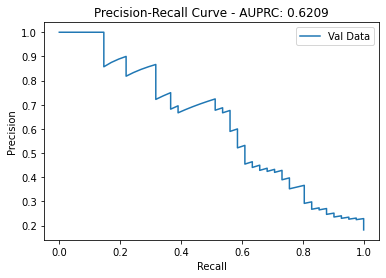

Val Result:

Accuracy Score: 85.33%
Precision Score: 66.67%
Recall Score: 39.02%
F1 score: 49.23%
Confusion Matrix:
[[176   8]
 [ 25  16]]
AUPRC: 0.6209
test Result:

Accuracy Score: 87.00%
Precision Score: 87.88%
Recall Score: 47.54%
F1 score: 61.70%
Confusion Matrix:
[[212   4]
 [ 32  29]]
Accuracy: 0.8


D:\kfcteam-cy\Anaconda3\envs\pangolin\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


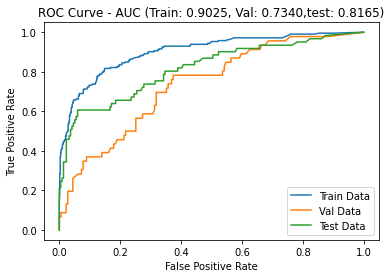

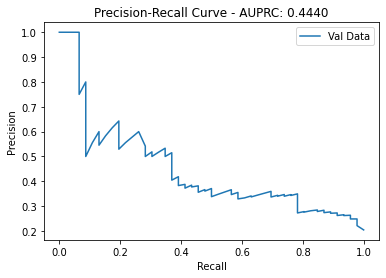

Val Result:

Accuracy Score: 80.00%
Precision Score: 51.85%
Recall Score: 30.43%
F1 score: 38.36%
Confusion Matrix:
[[166  13]
 [ 32  14]]
AUPRC: 0.4440
test Result:

Accuracy Score: 85.92%
Precision Score: 78.95%
Recall Score: 49.18%
F1 score: 60.61%
Confusion Matrix:
[[208   8]
 [ 31  30]]


D:\kfcteam-cy\Anaconda3\envs\pangolin\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Accuracy: 0.8392857142857143


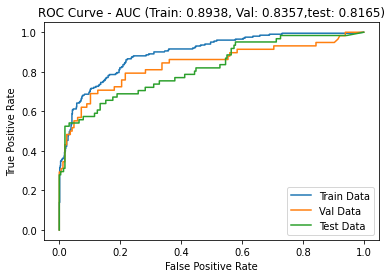

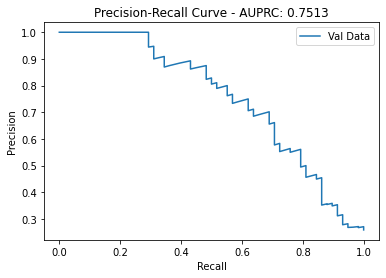

Val Result:

Accuracy Score: 83.93%
Precision Score: 82.35%
Recall Score: 48.28%
F1 score: 60.87%
Confusion Matrix:
[[160   6]
 [ 30  28]]
AUPRC: 0.7513
test Result:

Accuracy Score: 87.00%
Precision Score: 87.88%
Recall Score: 47.54%
F1 score: 61.70%
Confusion Matrix:
[[212   4]
 [ 32  29]]


D:\kfcteam-cy\Anaconda3\envs\pangolin\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Accuracy: 0.8705357142857143


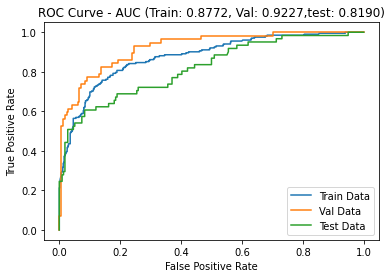

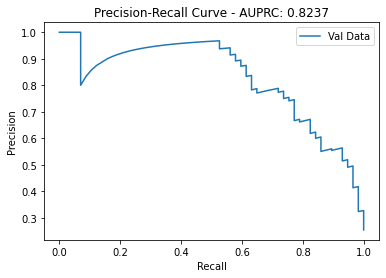

Val Result:

Accuracy Score: 87.05%
Precision Score: 93.75%
Recall Score: 52.63%
F1 score: 67.42%
Confusion Matrix:
[[165   2]
 [ 27  30]]
AUPRC: 0.8237
test Result:

Accuracy Score: 86.28%
Precision Score: 82.86%
Recall Score: 47.54%
F1 score: 60.42%
Confusion Matrix:
[[210   6]
 [ 32  29]]


In [76]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
count = 0
for train_index, test_index in kf.split(X_train_smote, y_train_smote):
    if count == 5:
        break
    count = count + 1 
    x_train, x_test = X_train_smote[train_index], X_train_smote[test_index]
    y_train, y_test_cv = y_train_smote[train_index], y_train_smote[test_index]

    # 創建XGBoost分類器
    xgb_model = XGBClassifier(**best_params, random_state=42)
    eval_set = [(x_test, y_test_cv)]

    # 訓練模型
    xgb_model.fit(x_train, y_train,early_stopping_rounds=5, eval_set=eval_set, verbose=False)
        
    # 在測試集上進行預測
    y_pred = xgb_model.predict(x_test)
    
    # 計算模型的準確率或其他評估指标
    accuracy = sklearn.metrics.accuracy_score(y_test_cv, y_pred)
    print("Accuracy:", accuracy)

    # 在訓練集和測試集上計算預測概率和ROC曲線數據
    y_pred_proba_train = xgb_model.predict_proba(x_train)
    xgb_fpr_train, xgb_tpr_train, _ = sklearn.metrics.roc_curve(y_train, y_pred_proba_train[:, 1])
    xgb_auc_train = sklearn.metrics.auc(xgb_fpr_train, xgb_tpr_train)

    y_pred_proba_test = xgb_model.predict_proba(x_test)
    xgb_fpr_test, xgb_tpr_test, _ = sklearn.metrics.roc_curve(y_test_cv, y_pred_proba_test[:, 1])
    xgb_auc_test = sklearn.metrics.auc(xgb_fpr_test, xgb_tpr_test)

    # 在測試集上進行預測
    y_pred_last = xgb_model.predict(X_test)

    y_pred_proba_last_test = xgb_model.predict_proba(X_test)
    xgb_fpr_last_test, xgb_tpr_last_test, _ = sklearn.metrics.roc_curve(y_test, y_pred_proba_last_test[:, 1])
    xgb_auc_last_test = sklearn.metrics.auc(xgb_fpr_last_test, xgb_tpr_last_test)
    

    # 計算精確率和召回率以繪製P-R曲線
    precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test_cv, y_pred_proba_test[:, 1])
    auprc = sklearn.metrics.auc(recall, precision)

    # 畫疊圖用
    # 計算精確率和召回率以繪製P-R曲線
    xgb_precision_last, xgb_recall_last, _ = sklearn.metrics.precision_recall_curve(y_test, y_pred_proba_last_test[:, 1])
    xgb_auprc_last = sklearn.metrics.auc(xgb_recall_last, xgb_precision_last) 

    # 繪製ROC曲線
    plt.plot(xgb_fpr_train, xgb_tpr_train, label="Train Data")
    plt.plot(xgb_fpr_test, xgb_tpr_test, label="Val Data")
    plt.plot(xgb_fpr_last_test, xgb_tpr_last_test, label="Test Data")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - AUC (Train: {xgb_auc_train:.4f}, Val: {xgb_auc_test:.4f},test: {xgb_auc_last_test:.4f})')
    plt.legend()
    plt.show()

    # 繪製P-R曲線
    plt.plot(recall, precision, label="Val Data")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - AUPRC: {auprc:.4f}')
    plt.legend()
    plt.show()

    # 打印结果
    print("Val Result:\n")
    print(f"Accuracy Score: {accuracy_score(y_test_cv, y_pred)*100:.2f}%")
    print(f"Precision Score: {precision_score(y_test_cv, y_pred)*100:.2f}%")
    print(f"Recall Score: {recall_score(y_test_cv, y_pred)*100:.2f}%")
    print(f"F1 score: {f1_score(y_test_cv, y_pred)*100:.2f}%")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test_cv, y_pred)}")
    print(f"AUPRC: {auprc:.4f}")

    # 打印结果
    print("test Result:\n")
    print(f"Accuracy Score: {accuracy_score(y_test, y_pred_last)*100:.2f}%")
    print(f"Precision Score: {precision_score(y_test, y_pred_last)*100:.2f}%")
    print(f"Recall Score: {recall_score(y_test, y_pred_last)*100:.2f}%")
    print(f"F1 score: {f1_score(y_test, y_pred_last)*100:.2f}%")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_last)}")


In [24]:
best_index = np.argmax(grid.best_score_)  # 获取最佳得分的索引
best_train_score = means_train[best_index]
best_val_score = means_val[best_index]

print("Best Model Train Score:", best_train_score)
print("Best Model Validation Score:", best_val_score)

Best Model Train Score: 0.6997530569495443
Best Model Validation Score: 0.6872291926066547


GBM_SMOTE

最佳AUC: 0.8266551334463491，最佳參數組合：{'learning_rate': 0.01, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 250, 'subsample': 0.8}
訓練集平均AUC: 0.9602657775758943, 標準差: 0.006574089644494209, 驗證集平均AUC: 0.8266551334463491, 標準差: 0.06637949371827534, 參數組合: {'learning_rate': 0.01, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 250, 'subsample': 0.8}


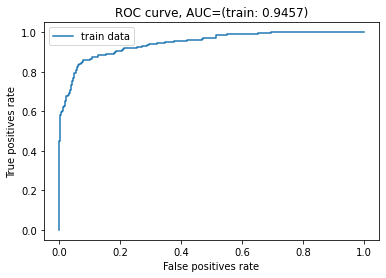

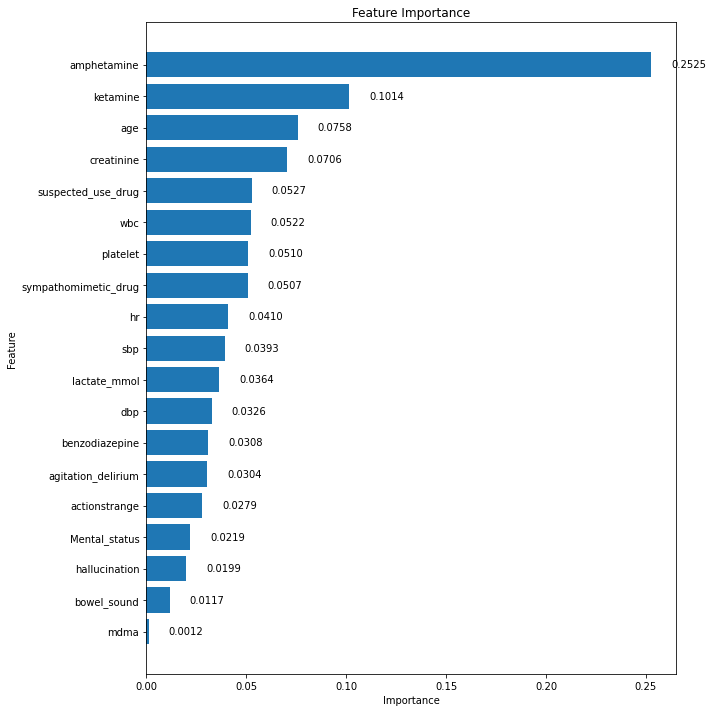

(1123, 19)


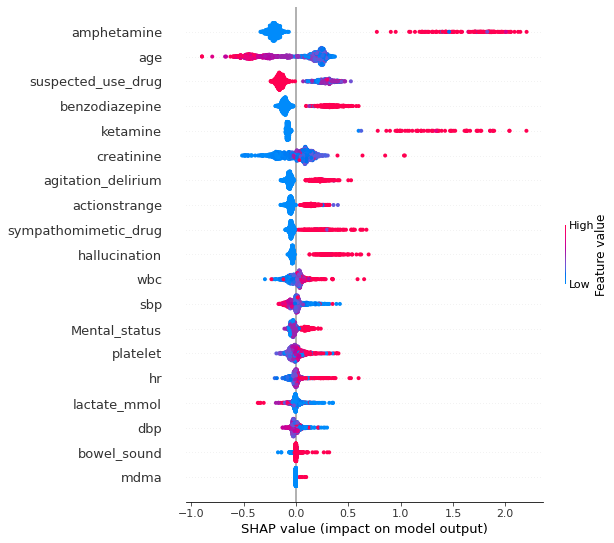

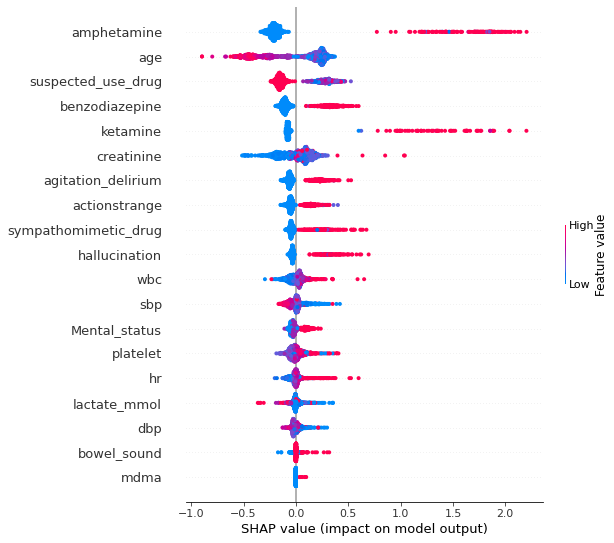

In [114]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# 定義參數空間
param_grid = {
    'n_estimators': [ 250],
    'learning_rate': [ 0.01],
    'max_depth': [5],
    'subsample': [0.8],
    'min_samples_split': [4],
    'min_samples_leaf': [2],
    'max_features': ['sqrt']
}
# 創建GBM模型
gbm = GradientBoostingClassifier()


# 定義Grid Search對象
grid_search = GridSearchCV(gbm, param_grid, cv=5,verbose=False,scoring = 'roc_auc',return_train_score=True,n_jobs=2)

# 在訓練數據上進行Grid Search
grid_search.fit(X_train_smote, y_train_smote)

gbm_best_params = grid_search.best_params_



# 使用最佳參數組合的模型進行預測
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

# 評估，打分數
print(f"最佳AUC: {grid_search.best_score_}，最佳參數組合：{grid_search.best_params_}")
# 取得 cross validation 的平均準確率及標準差

means_train = grid_search.cv_results_['mean_train_score']
stds_train = grid_search.cv_results_['std_train_score']
means_val = grid_search.cv_results_['mean_test_score']
stds_val = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean_train, stdev_train, mean_val, stdev_val, param in zip(means_train, stds_train, means_val, stds_val, params):
    print(f"訓練集平均AUC: {mean_train}, 標準差: {stdev_train}, 驗證集平均AUC: {mean_val}, 標準差: {stdev_val}, 參數組合: {param}")


# GBM
gbm = GradientBoostingClassifier(**gbm_best_params)
gbm.fit(X_train_smote, y_train_smote)

import matplotlib.pyplot as plt

y_pred_proba_train = gbm.predict_proba(X_train_smote)
fpr_train, tpr_train, _ = sklearn.metrics.roc_curve(y_train_smote, y_pred_proba_train[:, 1])

auc_train = sklearn.metrics.auc(fpr_train, tpr_train)


plt.title(f"ROC curve, AUC=(train: {auc_train:.4f})")
# plt.plot(fpr_val, tpr_val, label="val data")
plt.plot(fpr_train, tpr_train, label="train data")
plt.xlabel('False positives rate')
plt.ylabel('True positives rate')
plt.legend()


y_pred_proba_test = gbm.predict_proba(X_test)

# 使用模型進行預測
y_pred = gbm.predict(X_test)

predictions = [round(value) for value in y_pred]

# 取得特徵重要性
importance = gbm.feature_importances_

# 建立特徵重要性的資料框
feature_importances = pd.DataFrame({'Feature': l.columns, 'Importance': importance})
feature_importances = feature_importances.sort_values('Importance', ascending=False).reset_index(drop=True)

# 設定圖表大小
plt.figure(figsize=(10, 10))

# 繪製特徵重要性長條圖
plt.barh(feature_importances['Feature'], feature_importances['Importance'], align='center')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')

# 反轉Y軸，讓重要性高的項目顯示在上方
plt.gca().invert_yaxis()

# 顯示特徵重要性數值
for i, v in enumerate(feature_importances['Importance']):
    plt.text(v + 0.01, i, f'{v:.4f}', color='black', va='center')

# 調整Y軸刻度標籤
plt.yticks(range(len(feature_importances['Feature'])), feature_importances['Feature'])

plt.tight_layout()
plt.show()

import shap

# 建立SHAP TreeExplainer
explainer = shap.TreeExplainer(gbm)

# 將 X_train 轉換為 DataFrame 並指定特徵名稱
X_train_df = pd.DataFrame(X_train_smote, columns=l.columns)

# 計算SHAP值
shap_values = explainer.shap_values(X_train_df)

# 印出SHAP值的形狀
print(shap_values.shape)

# 繪製SHAP摘要圖
shap.summary_plot(shap_values, X_train_df)

# 繪製單個實例的SHAP力圖
shap.force_plot(explainer.expected_value, shap_values[0, :], X_train_df.iloc[0, :])

# 儲存SHAP摘要圖
shap.summary_plot(shap_values, X_train_df, show=False)
plt.savefig('shap.png', dpi=400)



Accuracy: 0.8444444444444444


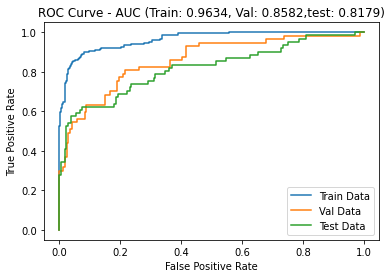

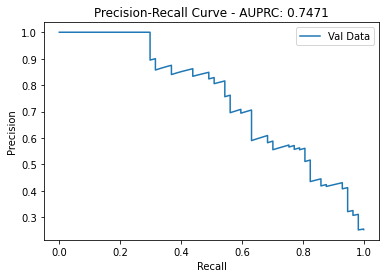

Val Result:

Accuracy Score: 84.44%
Precision Score: 84.38%
Recall Score: 47.37%
F1 score: 60.67%
Confusion Matrix:
[[163   5]
 [ 30  27]]
AUPRC: 0.7471
test Result:

Accuracy Score: 86.28%
Precision Score: 84.85%
Recall Score: 45.90%
F1 score: 59.57%
Confusion Matrix:
[[211   5]
 [ 33  28]]
Accuracy: 0.8533333333333334


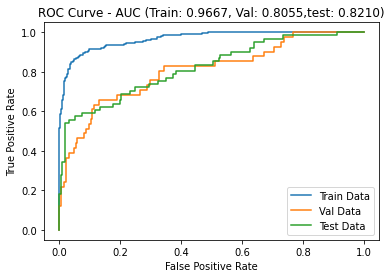

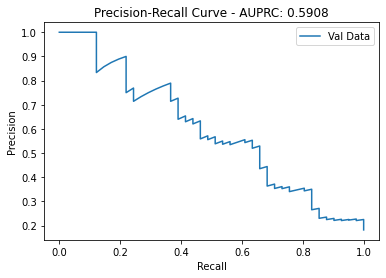

Val Result:

Accuracy Score: 85.33%
Precision Score: 66.67%
Recall Score: 39.02%
F1 score: 49.23%
Confusion Matrix:
[[176   8]
 [ 25  16]]
AUPRC: 0.5908
test Result:

Accuracy Score: 87.00%
Precision Score: 87.88%
Recall Score: 47.54%
F1 score: 61.70%
Confusion Matrix:
[[212   4]
 [ 32  29]]
Accuracy: 0.8088888888888889


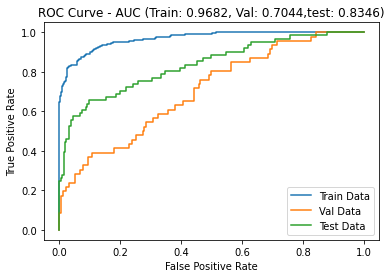

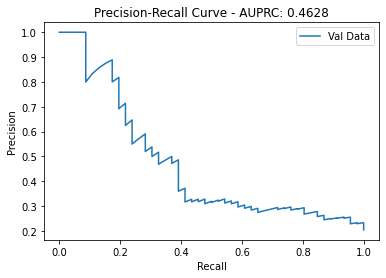

Val Result:

Accuracy Score: 80.89%
Precision Score: 56.52%
Recall Score: 28.26%
F1 score: 37.68%
Confusion Matrix:
[[169  10]
 [ 33  13]]
AUPRC: 0.4628
test Result:

Accuracy Score: 85.92%
Precision Score: 80.56%
Recall Score: 47.54%
F1 score: 59.79%
Confusion Matrix:
[[209   7]
 [ 32  29]]
Accuracy: 0.84375


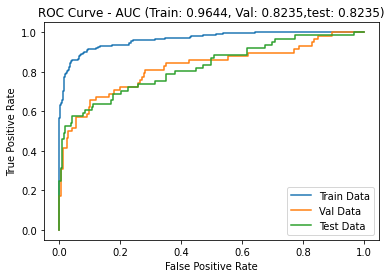

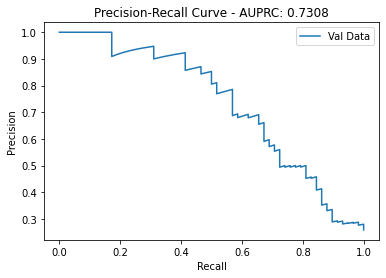

Val Result:

Accuracy Score: 84.38%
Precision Score: 84.85%
Recall Score: 48.28%
F1 score: 61.54%
Confusion Matrix:
[[161   5]
 [ 30  28]]
AUPRC: 0.7308
test Result:

Accuracy Score: 87.36%
Precision Score: 93.33%
Recall Score: 45.90%
F1 score: 61.54%
Confusion Matrix:
[[214   2]
 [ 33  28]]
Accuracy: 0.8660714285714286


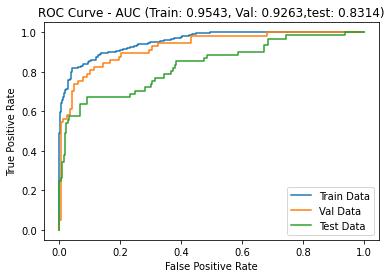

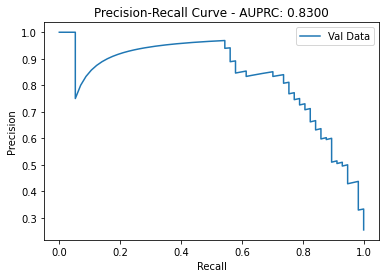

Val Result:

Accuracy Score: 86.61%
Precision Score: 96.55%
Recall Score: 49.12%
F1 score: 65.12%
Confusion Matrix:
[[166   1]
 [ 29  28]]
AUPRC: 0.8300
test Result:

Accuracy Score: 85.92%
Precision Score: 86.67%
Recall Score: 42.62%
F1 score: 57.14%
Confusion Matrix:
[[212   4]
 [ 35  26]]


In [75]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
count = 0
for train_index, test_index in kf.split(X_train_smote, y_train_smote):
    if count == 5:
        break
    count = count + 1 
    x_train, x_test = X_train_smote[train_index], X_train_smote[test_index]
    y_train, y_test_cv = y_train_smote[train_index], y_train_smote[test_index]

    # 創建XGBoost分類器
    gbm_model = GradientBoostingClassifier(**gbm_best_params, random_state=70)
    
    # 訓練模型
    gbm_model.fit(x_train, y_train)
    
    # 在測試集上進行預測
    y_pred = gbm_model.predict(x_test)
    
    # 計算模型的準確率或其他評估指标
    accuracy = sklearn.metrics.accuracy_score(y_test_cv, y_pred)
    print("Accuracy:", accuracy)

    # 在訓練集和測試集上計算預測概率和ROC曲線數據
    y_pred_proba_train = gbm_model.predict_proba(x_train)
    gbm_fpr_train, gbm_tpr_train, _ = sklearn.metrics.roc_curve(y_train, y_pred_proba_train[:, 1])
    gbm_auc_train = sklearn.metrics.auc(gbm_fpr_train, gbm_tpr_train)

    y_pred_proba_test = gbm_model.predict_proba(x_test)
    gbm_fpr_test, gbm_tpr_test, _ = sklearn.metrics.roc_curve(y_test_cv, y_pred_proba_test[:, 1])
    gbm_auc_test = sklearn.metrics.auc(gbm_fpr_test, gbm_tpr_test)

    # 在測試集上進行預測
    y_pred_last = gbm_model.predict(X_test)

    y_pred_proba_last_test = gbm_model.predict_proba(X_test)
    gbm_fpr_last_test, gbm_tpr_last_test, _ = sklearn.metrics.roc_curve(y_test, y_pred_proba_last_test[:, 1])
    gbm_auc_last_test = sklearn.metrics.auc(gbm_fpr_last_test, gbm_tpr_last_test)
    

    # 計算精確率和召回率以繪製P-R曲線
    precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test_cv, y_pred_proba_test[:, 1])
    auprc = sklearn.metrics.auc(recall, precision)

    # 畫疊圖用
    # 計算精確率和召回率以繪製P-R曲線
    gbm_precision_last, gbm_recall_last, _ = sklearn.metrics.precision_recall_curve(y_test, y_pred_proba_last_test[:, 1])
    gbm_auprc_last = sklearn.metrics.auc(gbm_recall_last, gbm_precision_last) 

    # 繪製ROC曲線
    plt.plot(gbm_fpr_train, gbm_tpr_train, label="Train Data")
    plt.plot(gbm_fpr_test, gbm_tpr_test, label="Val Data")
    plt.plot(gbm_fpr_last_test, gbm_tpr_last_test, label="Test Data")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - AUC (Train: {gbm_auc_train:.4f}, Val: {gbm_auc_test:.4f},test: {gbm_auc_last_test:.4f})')
    plt.legend()
    plt.show()

    # 繪製P-R曲線
    plt.plot(recall, precision, label="Val Data")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - AUPRC: {auprc:.4f}')
    plt.legend()
    plt.show()

    # 打印结果
    print("Val Result:\n")
    print(f"Accuracy Score: {accuracy_score(y_test_cv, y_pred)*100:.2f}%")
    print(f"Precision Score: {precision_score(y_test_cv, y_pred)*100:.2f}%")
    print(f"Recall Score: {recall_score(y_test_cv, y_pred)*100:.2f}%")
    print(f"F1 score: {f1_score(y_test_cv, y_pred)*100:.2f}%")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test_cv, y_pred)}")
    print(f"AUPRC: {auprc:.4f}")

    # 打印结果
    print("test Result:\n")
    print(f"Accuracy Score: {accuracy_score(y_test, y_pred_last)*100:.2f}%")
    print(f"Precision Score: {precision_score(y_test, y_pred_last)*100:.2f}%")
    print(f"Recall Score: {recall_score(y_test, y_pred_last)*100:.2f}%")
    print(f"F1 score: {f1_score(y_test, y_pred_last)*100:.2f}%")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_last)}")

In [112]:
gbm_best_params

{'learning_rate': 0.03,
 'max_depth': 7,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 100,
 'subsample': 0.6}

In [16]:
best_index = np.argmax(grid_search.best_score_)  # 获取最佳得分的索引
best_train_score = means_train[best_index]
best_val_score = means_val[best_index]

print("Best Model Train Score:", best_train_score)
print("Best Model Validation Score:", best_val_score)

Best Model Train Score: 0.9398336096954868
Best Model Validation Score: 0.8266687636618959


LDA_SMOTE

Fitting 5 folds for each of 6 candidates, totalling 30 fits
最佳AUC: 0.8315451950372836，最佳參數組合：{'n_components': None, 'priors': None, 'shrinkage': None, 'solver': 'svd', 'store_covariance': True, 'tol': 0.0001}
訓練集平均AUC: 0.8451332405394005, 標準差: 0.015532034217312255, 驗證集平均AUC: 0.8315451950372836, 標準差: 0.062426875747982, 參數組合: {'n_components': None, 'priors': None, 'shrinkage': None, 'solver': 'svd', 'store_covariance': True, 'tol': 0.0001}
訓練集平均AUC: 0.8451332405394005, 標準差: 0.015532034217312255, 驗證集平均AUC: 0.8315451950372836, 標準差: 0.062426875747982, 參數組合: {'n_components': None, 'priors': None, 'shrinkage': None, 'solver': 'svd', 'store_covariance': True, 'tol': 1e-05}
訓練集平均AUC: 0.8451332405394005, 標準差: 0.015532034217312255, 驗證集平均AUC: 0.8315451950372836, 標準差: 0.062426875747982, 參數組合: {'n_components': None, 'priors': None, 'shrinkage': None, 'solver': 'svd', 'store_covariance': True, 'tol': 1e-06}
訓練集平均AUC: 0.8451332405394005, 標準差: 0.015532034217312255, 驗證集平均AUC: 0.8315451950372836, 標準差: 0.

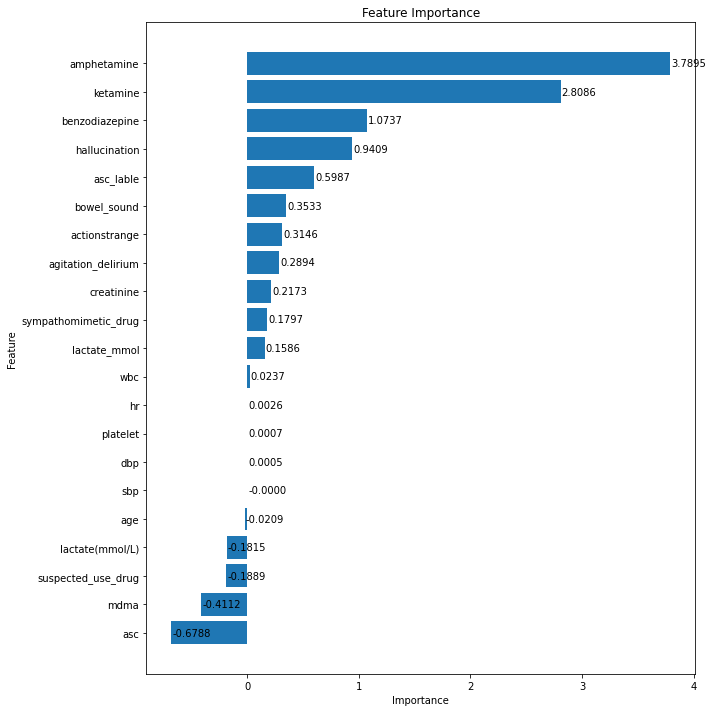

In [25]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_curve
# 定義參數空間
param_grid = {
    'solver': ['svd', 'lsqr'],
    'shrinkage': [None],
    'priors': [ None],
    'n_components' : [None], 
    'store_covariance' : [True], 
    'tol' : [1e-4,1e-5,1e-6]
}

# 創建LDA模型
lda = LinearDiscriminantAnalysis()

# 定義Grid Search對象
grid_search_lda = GridSearchCV(lda, param_grid, cv=5,verbose=True,scoring = 'roc_auc',return_train_score=True,n_jobs=2)

grid_search_lda.fit(X_train_smote, y_train_smote)

# 評估，打分數
print(f"最佳AUC: {grid_search_lda.best_score_}，最佳參數組合：{grid_search_lda.best_params_}")
# 取得 cross validation 的平均準確率及標準差

means_train = grid_search_lda.cv_results_['mean_train_score']
stds_train = grid_search_lda.cv_results_['std_train_score']
means_val = grid_search_lda.cv_results_['mean_test_score']
stds_val = grid_search_lda.cv_results_['std_test_score']
params = grid_search_lda.cv_results_['params']
for mean_train, stdev_train, mean_val, stdev_val, param in zip(means_train, stds_train, means_val, stds_val, params):
    print(f"訓練集平均AUC: {mean_train}, 標準差: {stdev_train}, 驗證集平均AUC: {mean_val}, 標準差: {stdev_val}, 參數組合: {param}")
    
lda_best_params = grid_search_lda.best_params_

# 使用最佳參數組合的模型進行預測
lda = LinearDiscriminantAnalysis(**lda_best_params)
lda.fit(X_train_smote, y_train_smote)

# 取得特徵重要性
importance = lda.coef_[0]

# 建立特徵重要性的資料框
feature_importances = pd.DataFrame({'Feature': dataset.columns[1:], 'Importance': importance})
feature_importances = feature_importances.sort_values('Importance', ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, 10))

# 繪製特徵重要性
plt.barh(feature_importances['Feature'], feature_importances['Importance'], align='center')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')

plt.gca().invert_yaxis()

# 顯示特徵重要性值
for i, v in enumerate(feature_importances['Importance']):
    plt.text(v + 0.01, i, f'{v:.4f}', color='black', va='center')

plt.yticks(range(len(feature_importances['Feature'])), feature_importances['Feature'])

plt.tight_layout()
plt.show()

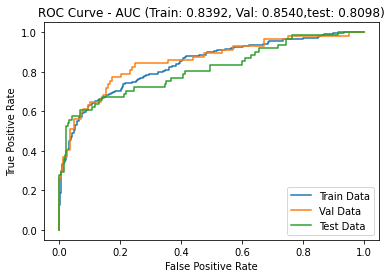

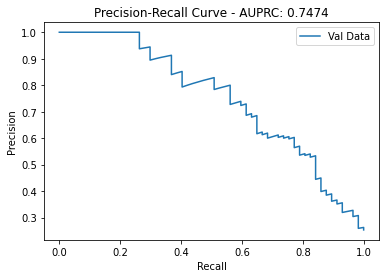

Val Result:

Accuracy Score: 84.44%
Precision Score: 78.95%
Recall Score: 52.63%
F1 score: 63.16%
Confusion Matrix:
[[160   8]
 [ 27  30]]
AUPRC: 0.7474
test Result:

Accuracy Score: 86.28%
Precision Score: 84.85%
Recall Score: 45.90%
F1 score: 59.57%
Confusion Matrix:
[[211   5]
 [ 33  28]]


In [74]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
count = 0
for train_index, test_index in kf.split(X_train_smote, y_train_smote):
    if count == 1:
        break
    count = count + 1 
    x_train, x_test = X_train_smote[train_index], X_train_smote[test_index]
    y_train, y_test_cv = y_train_smote[train_index], y_train_smote[test_index]

    # 創建LDA
    lda_model = LinearDiscriminantAnalysis(**lda_best_params)
    
    # 訓練模型
    lda_model.fit(x_train, y_train)
    
    # 在測試集上進行預測
    y_pred = lda_model.predict(x_test)
    
    # 計算模型的準確率或其他評估指標
    accuracy = sklearn.metrics.accuracy_score(y_test_cv, y_pred)
    # print("Accuracy:", accuracy)

    # 在訓練集和測試集上計算預測概率和ROC曲線數據
    y_pred_proba_train = lda_model.predict_proba(x_train)
    lda_fpr_train, lda_tpr_train, _ = sklearn.metrics.roc_curve(y_train, y_pred_proba_train[:, 1])
    lda_auc_train = sklearn.metrics.auc(lda_fpr_train, lda_tpr_train)

    y_pred_proba_test = lda_model.predict_proba(x_test)
    lda_fpr_test, lda_tpr_test, _ = sklearn.metrics.roc_curve(y_test_cv, y_pred_proba_test[:, 1])
    lda_auc_test = sklearn.metrics.auc(lda_fpr_test, lda_tpr_test)

    # 在測試集上進行預測
    y_pred_last = lda_model.predict(X_test)

    y_pred_proba_last_test = lda_model.predict_proba(X_test)
    lda_fpr_last_test, lda_tpr_last_test, _ = sklearn.metrics.roc_curve(y_test, y_pred_proba_last_test[:, 1])
    lda_auc_last_test = sklearn.metrics.auc(lda_fpr_last_test, lda_tpr_last_test)
  

    # 計算精確率和召回率以繪製P-R曲線
    precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test_cv, y_pred_proba_test[:, 1])
    auprc = sklearn.metrics.auc(recall, precision)

     # 畫疊圖用
    # 計算精確率和召回率以繪製P-R曲線
    lda_precision_last, lda_recall_last, _ = sklearn.metrics.precision_recall_curve(y_test, y_pred_proba_last_test[:, 1])
    lda_auprc_last = sklearn.metrics.auc(lda_recall_last, lda_precision_last) 

    # 繪製ROC曲線
    plt.plot(lda_fpr_train, lda_tpr_train, label="Train Data")
    plt.plot(lda_fpr_test, lda_tpr_test, label="Val Data")
    plt.plot(lda_fpr_last_test, lda_tpr_last_test, label="Test Data")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - AUC (Train: {lda_auc_train:.4f}, Val: {lda_auc_test:.4f},test: {lda_auc_last_test:.4f})')
    plt.legend()
    plt.show()

    # 繪製P-R曲線
    plt.plot(recall, precision, label="Val Data")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - AUPRC: {auprc:.4f}')
    plt.legend()
    plt.show()

    # 打印结果
    print("Val Result:\n")
    print(f"Accuracy Score: {accuracy_score(y_test_cv, y_pred)*100:.2f}%")
    print(f"Precision Score: {precision_score(y_test_cv, y_pred)*100:.2f}%")
    print(f"Recall Score: {recall_score(y_test_cv, y_pred)*100:.2f}%")
    print(f"F1 score: {f1_score(y_test_cv, y_pred)*100:.2f}%")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test_cv, y_pred)}")
    print(f"AUPRC: {auprc:.4f}")

    # 打印结果
    print("test Result:\n")
    print(f"Accuracy Score: {accuracy_score(y_test, y_pred_last)*100:.2f}%")
    print(f"Precision Score: {precision_score(y_test, y_pred_last)*100:.2f}%")
    print(f"Recall Score: {recall_score(y_test, y_pred_last)*100:.2f}%")
    print(f"F1 score: {f1_score(y_test, y_pred_last)*100:.2f}%")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_last)}")

MLR

D:\kfcteam-cy\Anaconda3\envs\pangolin\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
90 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "D:\kfcteam-cy\Anaconda3\envs\pangolin\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\kfcteam-cy\Anaconda3\envs\pangolin\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "D:\kfcteam-cy\Anaconda3\envs\pangolin\lib\site-packages\sklearn\linear_model\_logistic.py", 

最佳AUC: 0.8315103338221761，最佳參數組合：{'C': 1.0, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
訓練集平均AUC: 0.7169062934003528, 標準差: 0.011250459819113424, 驗證集平均AUC: 0.7095060210171943, 標準差: 0.03590950010000704, 參數組合: {'C': 0.1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
訓練集平均AUC: nan, 標準差: nan, 驗證集平均AUC: nan, 標準差: nan, 參數組合: {'C': 0.1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'lbfgs'}
訓練集平均AUC: nan, 標準差: nan, 驗證集平均AUC: nan, 標準差: nan, 參數組合: {'C': 0.1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'newton-cg'}
訓練集平均AUC: 0.7212800451283856, 標準差: 0.011414327367135685, 驗證集平均AUC: 0.7135231253410088, 標準差: 0.0363671462300146, 參數組合: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}
訓練集平均AUC: 0.8058731131649317, 標準差: 0.015932753939166128, 驗證集平均AUC: 0.7904160931230113, 標準差: 0.052620055980623984, 參數組合: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
訓練集平均AUC: 0.8447224557388072, 標準差: 0.01500447171228762, 驗證集平均AUC: 0.8289310854477148, 標準差: 0.061452395474759

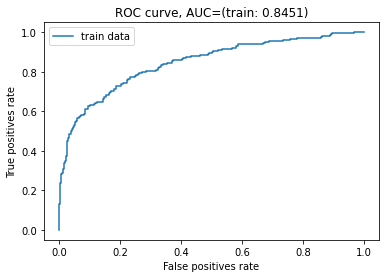

In [27]:
from sklearn.linear_model import LogisticRegression

# 定義參數空間
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1.0, 10.0],
    'solver': ['saga', 'lbfgs', 'newton-cg'],
    'max_iter': [100, 200, 500]
}

mlr = LogisticRegression(multi_class='multinomial')


# 定義Grid Search對象
grid_search = GridSearchCV(mlr, param_grid, cv=5,verbose=False,scoring = 'roc_auc',return_train_score=True,n_jobs=2)

# 在訓練數據上進行Grid Search
grid_search.fit(X_train_smote, y_train_smote)


mlr_best_params = grid_search.best_params_



# 使用最佳參數組合的模型進行預測
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)


# 評估，打分數
print(f"最佳AUC: {grid_search.best_score_}，最佳參數組合：{grid_search.best_params_}")
# 取得 cross validation 的平均準確率及標準差

means_train = grid_search.cv_results_['mean_train_score']
stds_train = grid_search.cv_results_['std_train_score']
means_val = grid_search.cv_results_['mean_test_score']
stds_val = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean_train, stdev_train, mean_val, stdev_val, param in zip(means_train, stds_train, means_val, stds_val, params):
    print(f"訓練集平均AUC: {mean_train}, 標準差: {stdev_train}, 驗證集平均AUC: {mean_val}, 標準差: {stdev_val}, 參數組合: {param}")


# MLR
mlr = LogisticRegression(**mlr_best_params,multi_class='multinomial')
mlr.fit(X_train_smote, y_train_smote)

y_pred_proba_train = mlr.predict_proba(X_train_smote)

fpr_train, tpr_train, _ = sklearn.metrics.roc_curve(y_train_smote, y_pred_proba_train[:, 1])

auc_train = sklearn.metrics.auc(fpr_train, tpr_train)


plt.title(f"ROC curve, AUC=(train: {auc_train:.4f})")
# plt.plot(fpr_val, tpr_val, label="val data")
plt.plot(fpr_train, tpr_train, label="train data")
plt.xlabel('False positives rate')
plt.ylabel('True positives rate')
plt.legend()


y_pred_proba_test = mlr.predict_proba(X_test)

# 使用模型進行預測
y_pred = mlr.predict(X_test)

predictions = [round(value) for value in y_pred]



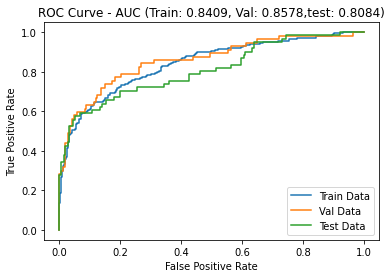

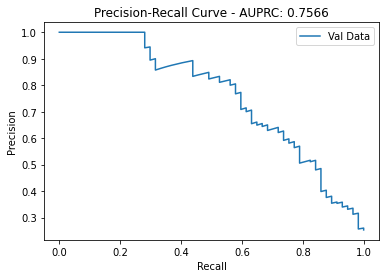

Val Result:

Accuracy Score: 84.89%
Precision Score: 82.86%
Recall Score: 50.88%
F1 score: 63.04%
Confusion Matrix:
[[162   6]
 [ 28  29]]
AUPRC: 0.7566
test Result:

Accuracy Score: 85.56%
Precision Score: 80.00%
Recall Score: 45.90%
F1 score: 58.33%
Confusion Matrix:
[[209   7]
 [ 33  28]]


In [80]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
count = 0
for train_index, test_index in kf.split(X_train_smote, y_train_smote):
    if count == 1:
        break
    count = count + 1 
    x_train, x_test = X_train_smote[train_index], X_train_smote[test_index]
    y_train, y_test_cv = y_train_smote[train_index], y_train_smote[test_index]

    # 創建mlr
    mlr_model = LogisticRegression(**mlr_best_params,multi_class='multinomial')
    
    # 訓練模型
    mlr_model.fit(x_train, y_train)
    
    # 在測試集上進行預測
    y_pred = mlr_model.predict(x_test)
    
    # 計算模型的準確率或其他評估指標
    accuracy = sklearn.metrics.accuracy_score(y_test_cv, y_pred)
    # print("Accuracy:", accuracy)

    # 在訓練集和測試集上計算預測概率和ROC曲線數據
    y_pred_proba_train = mlr_model.predict_proba(x_train)
    mlr_fpr_train, mlr_tpr_train, _ = sklearn.metrics.roc_curve(y_train, y_pred_proba_train[:, 1])
    mlr_auc_train = sklearn.metrics.auc(mlr_fpr_train, mlr_tpr_train)

    y_pred_proba_test = mlr_model.predict_proba(x_test)
    mlr_fpr_test, mlr_tpr_test, _ = sklearn.metrics.roc_curve(y_test_cv, y_pred_proba_test[:, 1])
    mlr_auc_test = sklearn.metrics.auc(mlr_fpr_test, mlr_tpr_test)

    # 在測試集上進行預測
    y_pred_last = mlr_model.predict(X_test)

    y_pred_proba_last_test = mlr_model.predict_proba(X_test)
    mlr_fpr_last_test, mlr_tpr_last_test, _ = sklearn.metrics.roc_curve(y_test, y_pred_proba_last_test[:, 1])
    mlr_auc_last_test = sklearn.metrics.auc(mlr_fpr_last_test, mlr_tpr_last_test)

     # 畫疊圖用
    # 計算精確率和召回率以繪製P-R曲線
    mlr_precision_last, mlr_recall_last, _ = sklearn.metrics.precision_recall_curve(y_test, y_pred_proba_last_test[:, 1])
    mlr_auprc_last = sklearn.metrics.auc(mlr_recall_last, mlr_precision_last)   

    # 計算精確率和召回率以繪製P-R曲線
    precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test_cv, y_pred_proba_test[:, 1])
    auprc = sklearn.metrics.auc(recall, precision)

    # 繪製ROC曲線
    plt.plot(mlr_fpr_train, mlr_tpr_train, label="Train Data")
    plt.plot(mlr_fpr_test, mlr_tpr_test, label="Val Data")
    plt.plot(mlr_fpr_last_test, mlr_tpr_last_test, label="Test Data")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - AUC (Train: {mlr_auc_train:.4f}, Val: {mlr_auc_test:.4f},test: {mlr_auc_last_test:.4f})')
    plt.legend()
    plt.show()

    # 繪製P-R曲線
    plt.plot(recall, precision, label="Val Data")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - AUPRC: {auprc:.4f}')
    plt.legend()
    plt.show()

    # 打印结果
    print("Val Result:\n")
    print(f"Accuracy Score: {accuracy_score(y_test_cv, y_pred)*100:.2f}%")
    print(f"Precision Score: {precision_score(y_test_cv, y_pred)*100:.2f}%")
    print(f"Recall Score: {recall_score(y_test_cv, y_pred)*100:.2f}%")
    print(f"F1 score: {f1_score(y_test_cv, y_pred)*100:.2f}%")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test_cv, y_pred)}")
    print(f"AUPRC: {auprc:.4f}")

    # 打印结果
    print("test Result:\n")
    print(f"Accuracy Score: {accuracy_score(y_test, y_pred_last)*100:.2f}%")
    print(f"Precision Score: {precision_score(y_test, y_pred_last)*100:.2f}%")
    print(f"Recall Score: {recall_score(y_test, y_pred_last)*100:.2f}%")
    print(f"F1 score: {f1_score(y_test, y_pred_last)*100:.2f}%")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_last)}")

MLP

In [35]:
from sklearn.neural_network import MLPClassifier

# 定義參數空間
param_grid = {
    'hidden_layer_sizes': [(100,)],
    'activation': ['relu'],
    'solver': ['adam', 'sgd'],
    'max_iter': [100],
    'alpha': [0.001],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1]
}
# 最佳AUC: 0.7482415475936308，最佳參數組合：{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}
mlp = MLPClassifier(early_stopping=True)

# 定義Grid Search對象
grid_search = GridSearchCV(mlp, param_grid, cv=5, verbose=False, scoring='roc_auc', return_train_score=True, n_jobs=1)

# 在訓練數據上進行Grid Search
grid_search.fit(X_train_smote, y_train_smote)

mlp_best_params = grid_search.best_params_

# 使用最佳參數組合的模型進行預測
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

# 評估，打分數
print(f"最佳AUC: {grid_search.best_score_}，最佳參數組合：{grid_search.best_params_}")
# 取得 cross validation 的平均準確率及標準差
means_train = grid_search.cv_results_['mean_train_score']
stds_train = grid_search.cv_results_['std_train_score']
means_val = grid_search.cv_results_['mean_test_score']
stds_val = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean_train, stdev_train, mean_val, stdev_val, param in zip(means_train, stds_train, means_val, stds_val, params):
    print(f"訓練集平均AUC: {mean_train}, 標準差: {stdev_train}, 驗證集平均AUC: {mean_val}, 標準差: {stdev_val}, 參數組合: {param}")


D:\kfcteam-cy\Anaconda3\envs\pangolin\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


最佳AUC: 0.737503081878413，最佳參數組合：{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}
訓練集平均AUC: 0.586879707659928, 標準差: 0.09715773511692452, 驗證集平均AUC: 0.5358977957878427, 標準差: 0.08767095893682528, 參數組合: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}
訓練集平均AUC: 0.5578842467380255, 標準差: 0.09021251208808385, 驗證集平均AUC: 0.5487092403838805, 標準差: 0.11502052667165086, 參數組合: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'sgd'}
訓練集平均AUC: 0.7490473956383621, 標準差: 0.01805209457102166, 驗證集平均AUC: 0.737503081878413, 標準差: 0.05876875990531763, 參數組合: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_i

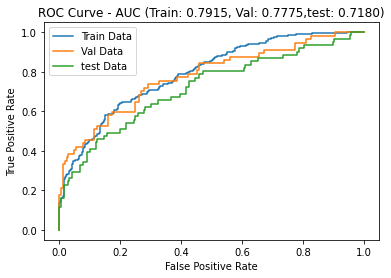

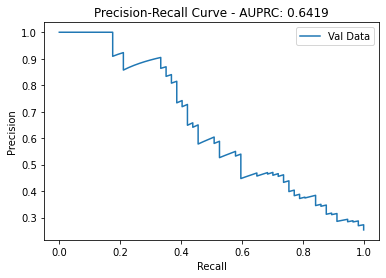

Val Result:

Accuracy Score: 76.44%
Precision Score: 100.00%
Recall Score: 7.02%
F1 score: 13.11%
Confusion Matrix:
[[168   0]
 [ 53   4]]
AUPRC: 0.6419
test Result:

Accuracy Score: 79.42%
Precision Score: 100.00%
Recall Score: 6.56%
F1 score: 12.31%
Confusion Matrix:
[[216   0]
 [ 57   4]]


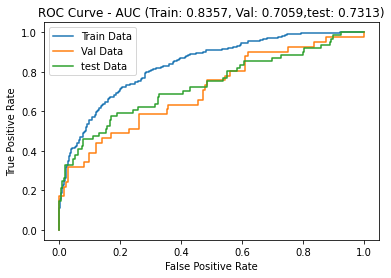

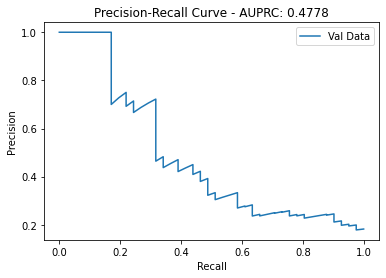

Val Result:

Accuracy Score: 84.44%
Precision Score: 75.00%
Recall Score: 21.95%
F1 score: 33.96%
Confusion Matrix:
[[181   3]
 [ 32   9]]
AUPRC: 0.4778
test Result:

Accuracy Score: 82.31%
Precision Score: 80.00%
Recall Score: 26.23%
F1 score: 39.51%
Confusion Matrix:
[[212   4]
 [ 45  16]]


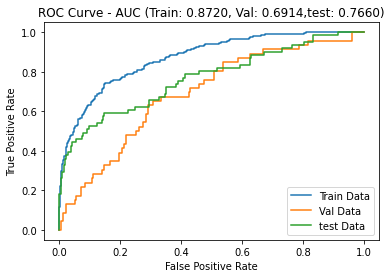

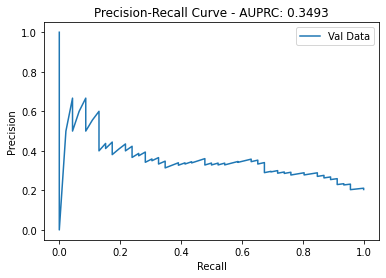

Val Result:

Accuracy Score: 73.33%
Precision Score: 34.78%
Recall Score: 34.78%
F1 score: 34.78%
Confusion Matrix:
[[149  30]
 [ 30  16]]
AUPRC: 0.3493
test Result:

Accuracy Score: 79.06%
Precision Score: 52.17%
Recall Score: 59.02%
F1 score: 55.38%
Confusion Matrix:
[[183  33]
 [ 25  36]]


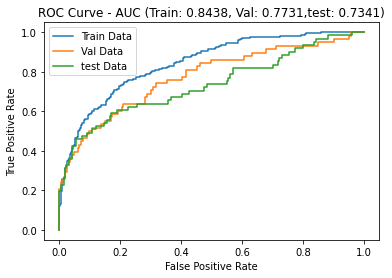

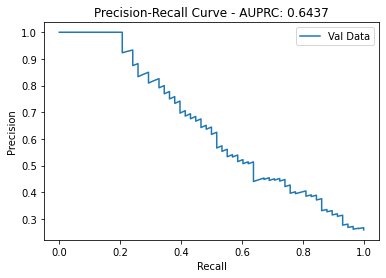

Val Result:

Accuracy Score: 79.91%
Precision Score: 80.95%
Recall Score: 29.31%
F1 score: 43.04%
Confusion Matrix:
[[162   4]
 [ 41  17]]
AUPRC: 0.6437
test Result:

Accuracy Score: 82.67%
Precision Score: 93.33%
Recall Score: 22.95%
F1 score: 36.84%
Confusion Matrix:
[[215   1]
 [ 47  14]]


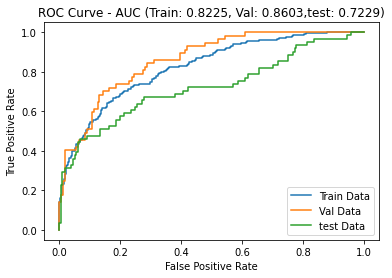

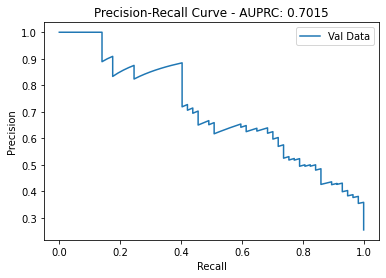

Val Result:

Accuracy Score: 79.91%
Precision Score: 83.33%
Recall Score: 26.32%
F1 score: 40.00%
Confusion Matrix:
[[164   3]
 [ 42  15]]
AUPRC: 0.7015
test Result:

Accuracy Score: 83.39%
Precision Score: 82.61%
Recall Score: 31.15%
F1 score: 45.24%
Confusion Matrix:
[[212   4]
 [ 42  19]]


In [81]:
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
count = 0
kf = KFold(n_splits=5)
for train_index, test_index in kf.split(X_train_smote, y_train_smote):
    if count == 5:
        break
    count = count + 1 
    x_train, x_test = X_train_smote[train_index], X_train_smote[test_index]
    y_train, y_test_cv = y_train_smote[train_index], y_train_smote[test_index]

    # 創建MLP模型
    mlp_model = MLPClassifier(**mlp_best_params, random_state=70)
    
    # 訓練模型
    mlp_model.fit(x_train, y_train)
    
    # 在測試集上進行預測
    y_pred = mlp_model.predict(x_test)
    
    # 計算模型的準確率或其他評估指標
    accuracy = sklearn.metrics.accuracy_score(y_test_cv, y_pred)
    # print("Accuracy:", accuracy)

    # 在訓練集和測試集上計算預測概率和ROC曲線數據
    y_pred_proba_train = mlp_model.predict_proba(x_train)
    mlp_fpr_train, mlp_tpr_train, _ = sklearn.metrics.roc_curve(y_train, y_pred_proba_train[:, 1])
    mlp_auc_train = sklearn.metrics.auc(mlp_fpr_train, mlp_tpr_train)

    y_pred_proba_test = mlp_model.predict_proba(x_test)
    mlp_fpr_test, mlp_tpr_test, _ = sklearn.metrics.roc_curve(y_test_cv, y_pred_proba_test[:, 1])
    mlp_auc_test = sklearn.metrics.auc(mlp_fpr_test, mlp_tpr_test)

    # 在測試集上進行預測
    y_pred_last = mlp_model.predict(X_test)

    y_pred_proba_last_test = mlp_model.predict_proba(X_test)
    mlp_fpr_last_test, mlp_tpr_last_test, _ = sklearn.metrics.roc_curve(y_test, y_pred_proba_last_test[:, 1])
    mlp_auc_last_test = sklearn.metrics.auc(mlp_fpr_last_test, mlp_tpr_last_test)
    

    # 計算精確率和召回率以繪製P-R曲線
    precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test_cv, y_pred_proba_test[:, 1])
    auprc = sklearn.metrics.auc(recall, precision)

    # 畫疊圖用
    # 計算精確率和召回率以繪製P-R曲線
    mlp_precision_last, mlp_recall_last, _ = sklearn.metrics.precision_recall_curve(y_test, y_pred_proba_last_test[:, 1])
    mlp_auprc_last = sklearn.metrics.auc(mlp_recall_last, mlp_precision_last)


    # 繪製ROC曲線
    plt.plot(mlp_fpr_train, mlp_tpr_train, label="Train Data")
    plt.plot(mlp_fpr_test, mlp_tpr_test, label="Val Data")
    plt.plot(mlp_fpr_last_test, mlp_tpr_last_test, label="test Data")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - AUC (Train: {mlp_auc_train:.4f}, Val: {mlp_auc_test:.4f},test: {mlp_auc_last_test:.4f})')
    plt.legend()
    plt.show()

    # 繪製P-R曲線
    plt.plot(recall, precision, label="Val Data")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - AUPRC: {auprc:.4f}')
    plt.legend()
    plt.show()

    
    # 打印结果
    print("Val Result:\n")
    print(f"Accuracy Score: {accuracy_score(y_test_cv, y_pred)*100:.2f}%")
    print(f"Precision Score: {precision_score(y_test_cv, y_pred)*100:.2f}%")
    print(f"Recall Score: {recall_score(y_test_cv, y_pred)*100:.2f}%")
    print(f"F1 score: {f1_score(y_test_cv, y_pred)*100:.2f}%")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test_cv, y_pred)}")
    print(f"AUPRC: {auprc:.4f}")

    # 打印结果
    print("test Result:\n")
    print(f"Accuracy Score: {accuracy_score(y_test, y_pred_last)*100:.2f}%")
    print(f"Precision Score: {precision_score(y_test, y_pred_last)*100:.2f}%")
    print(f"Recall Score: {recall_score(y_test, y_pred_last)*100:.2f}%")
    print(f"F1 score: {f1_score(y_test, y_pred_last)*100:.2f}%")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_last)}")

疊圖AUC-train

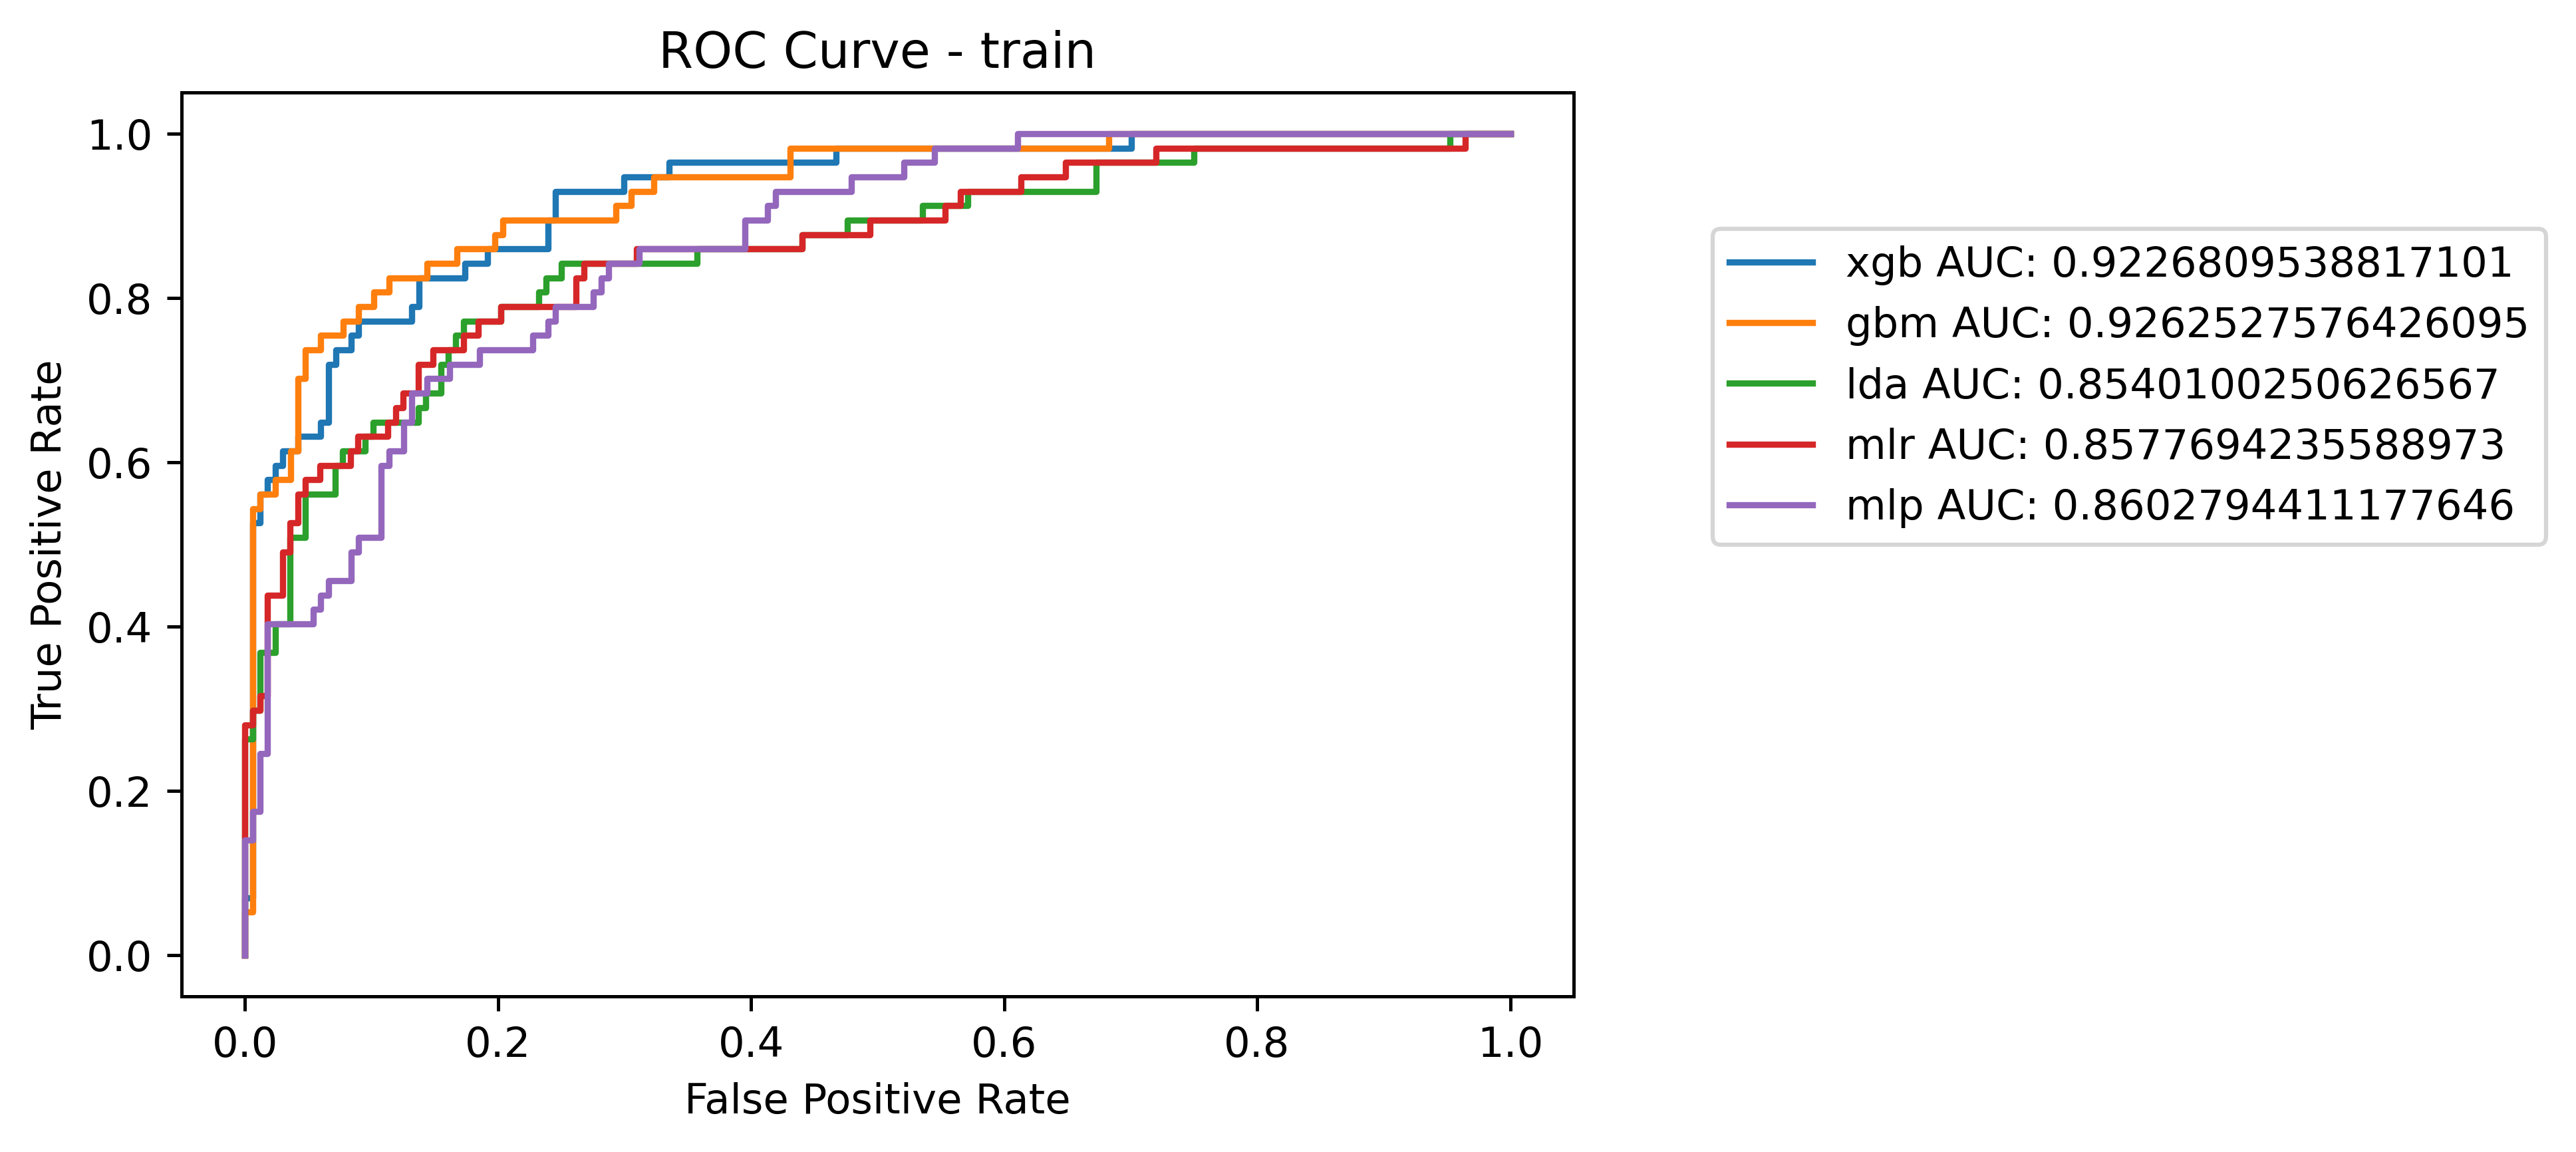

In [86]:
    # 繪製ROC曲線
    plt.figure(dpi=450)
    plt.plot(xgb_fpr_test, xgb_tpr_test, label="xgb AUC: "+str(xgb_auc_test))
    plt.plot(gbm_fpr_test, gbm_tpr_test, label="gbm AUC: "+str(gbm_auc_test))
    plt.plot(lda_fpr_test, lda_tpr_test, label="lda AUC: "+str(lda_auc_test))
    plt.plot(mlr_fpr_test, mlr_tpr_test, label="mlr AUC: "+str(mlr_auc_test))
    plt.plot(mlp_fpr_test, mlp_tpr_test, label="mlp AUC: "+str(mlp_auc_test))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - train')
    plt.legend(loc = (1.1,0.5))
    plt.show()

疊圖AUC-test

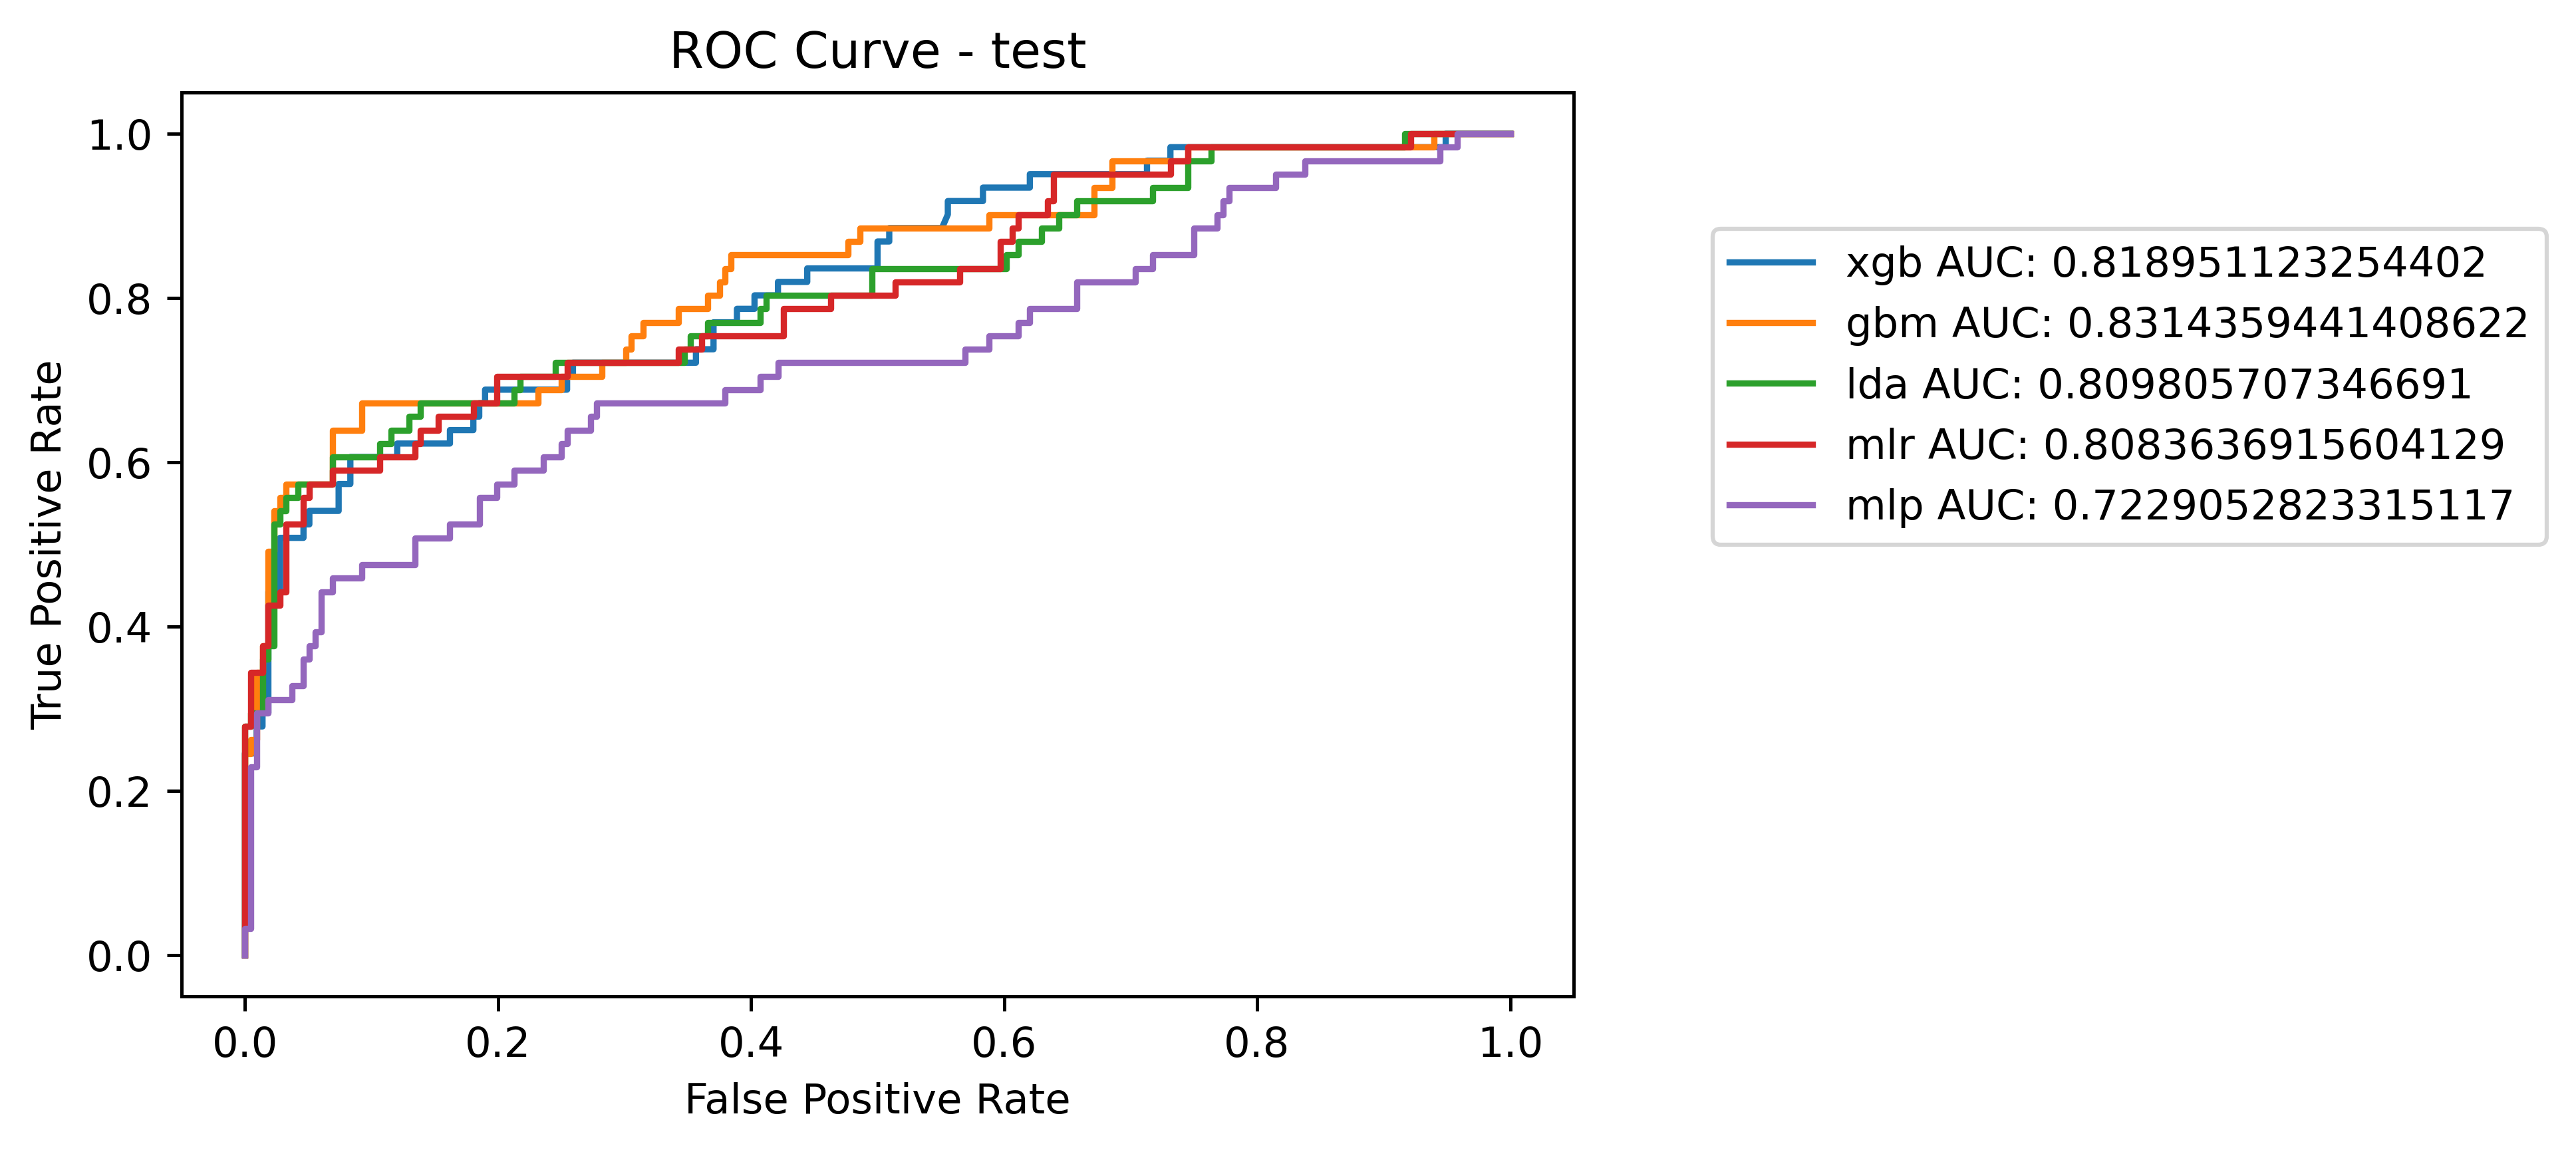

In [85]:
    # 繪製ROC曲線
    plt.figure(dpi=450)
    plt.plot(xgb_fpr_last_test, xgb_tpr_last_test, label="xgb AUC: "+str(xgb_auc_last_test))
    plt.plot(gbm_fpr_last_test, gbm_tpr_last_test, label="gbm AUC: "+str(gbm_auc_last_test))
    plt.plot(lda_fpr_last_test, lda_tpr_last_test, label="lda AUC: "+str(lda_auc_last_test))
    plt.plot(mlr_fpr_last_test, mlr_tpr_last_test, label="mlr AUC: "+str(mlr_auc_last_test))
    plt.plot(mlp_fpr_last_test, mlp_tpr_last_test, label="mlp AUC: "+str(mlp_auc_last_test))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - test')
    plt.legend(loc = (1.1,0.5))
    plt.show()

疊圖AUPRC-TEST

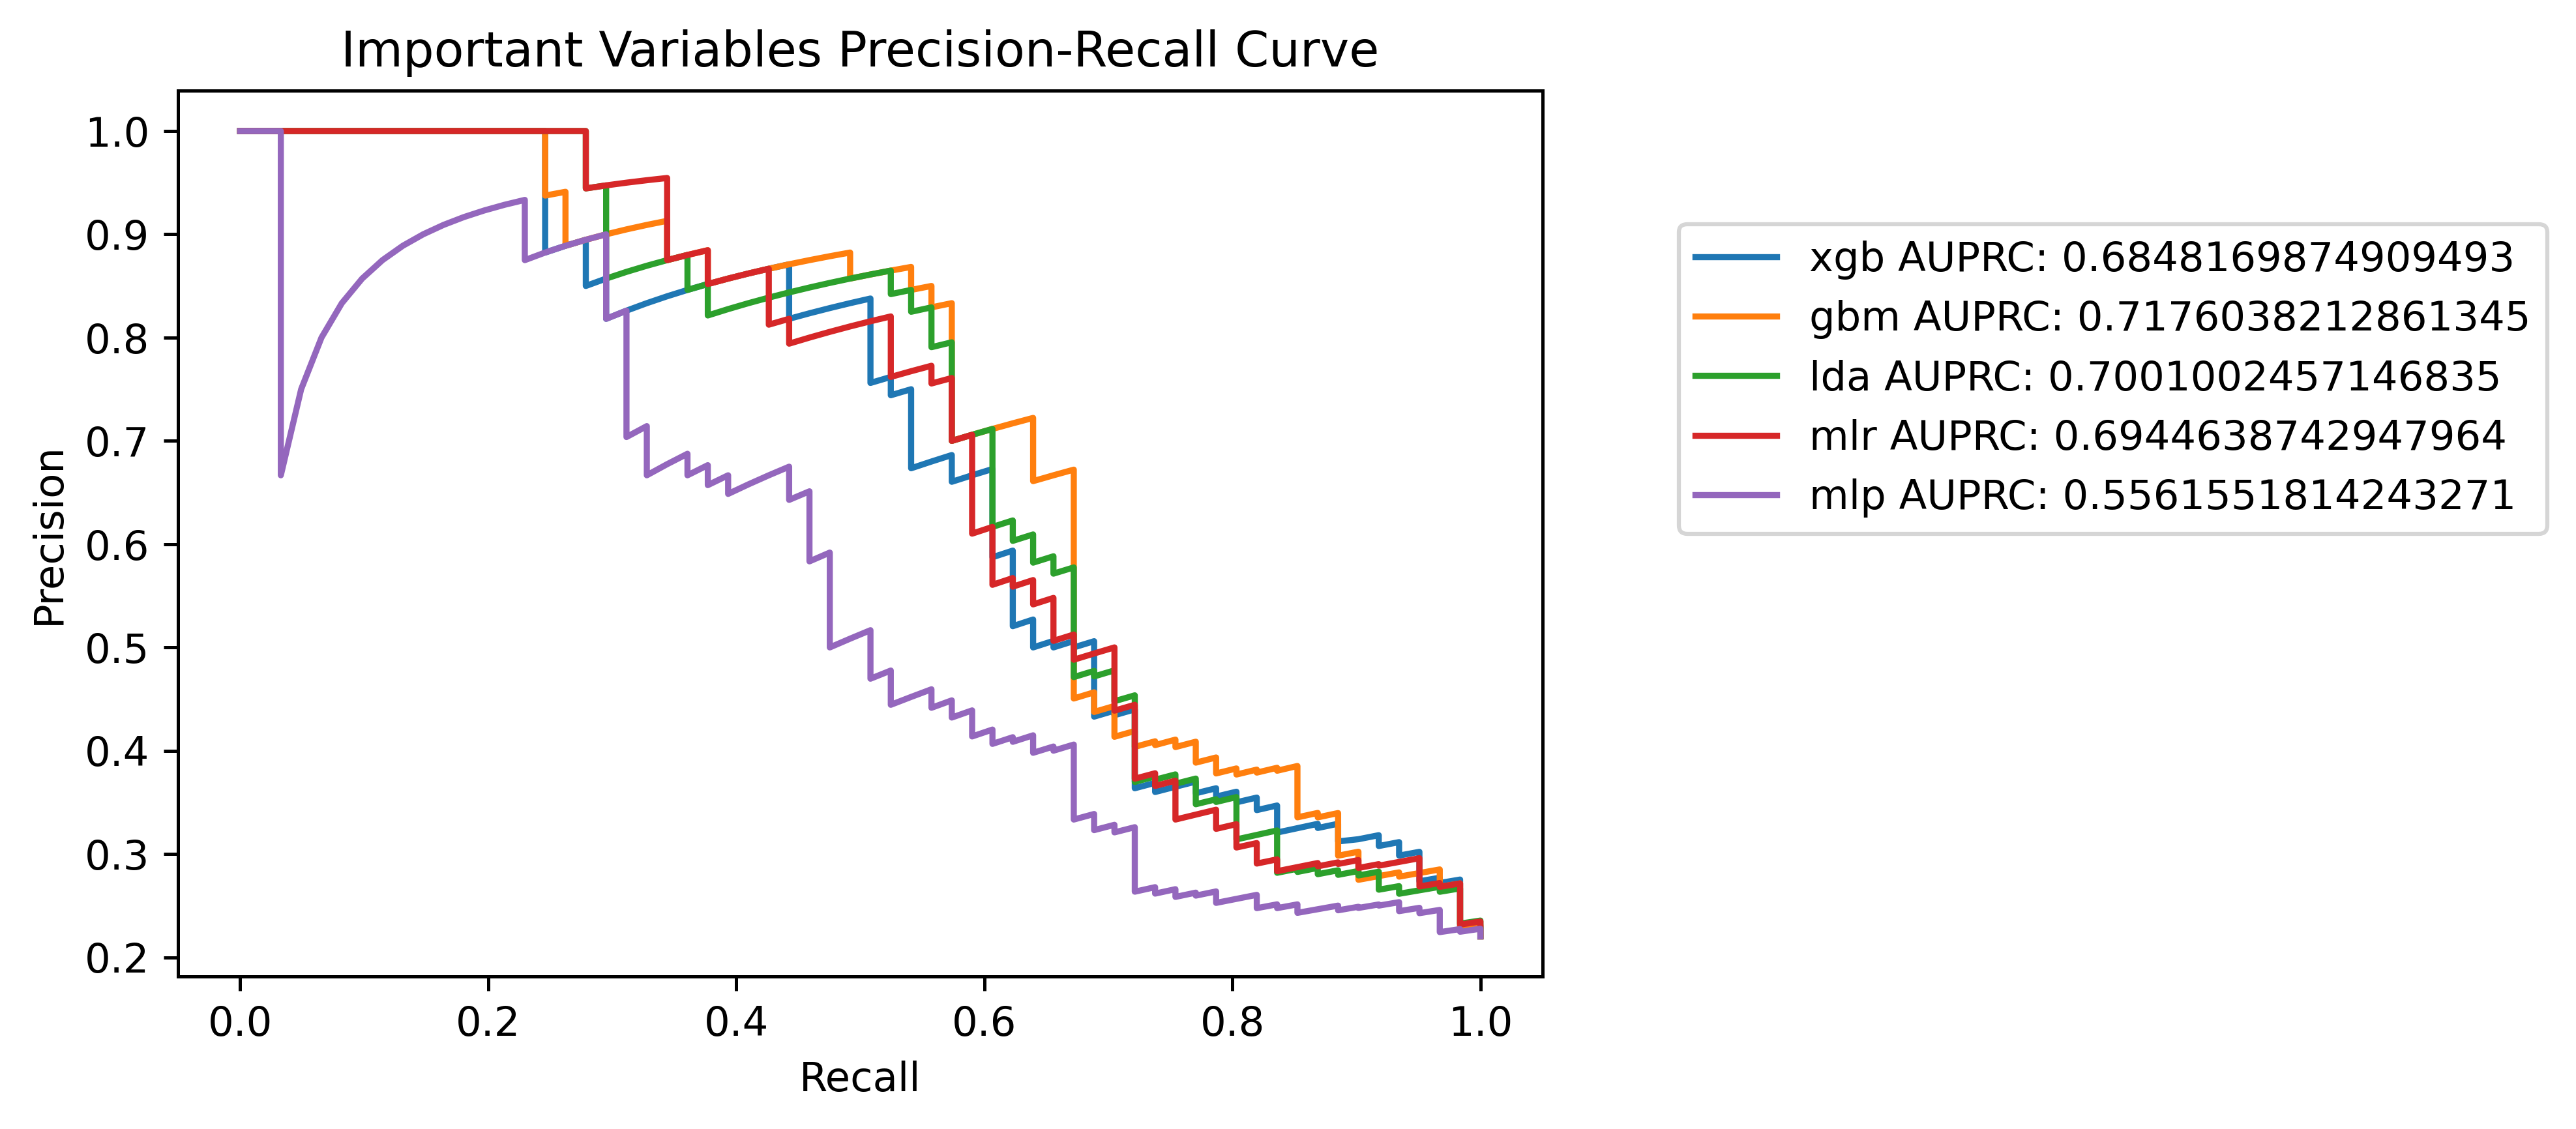

In [87]:
    # 繪製P-R曲線
    plt.figure(dpi=450)
    plt.plot(xgb_recall_last, xgb_precision_last, label="xgb AUPRC: "+str(xgb_auprc_last))
    plt.plot(gbm_recall_last, gbm_precision_last, label="gbm AUPRC: "+str(gbm_auprc_last))
    plt.plot(lda_recall_last, lda_precision_last, label="lda AUPRC: "+str(lda_auprc_last))
    plt.plot(mlr_recall_last, mlr_precision_last, label="mlr AUPRC: "+str(mlr_auprc_last))
    plt.plot(mlp_recall_last, mlp_precision_last, label="mlp AUPRC: "+str(mlp_auprc_last))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Important Variables Precision-Recall Curve')

    plt.legend(loc = (1.1,0.5))
    plt.show()

疊圖 train - test - xgb

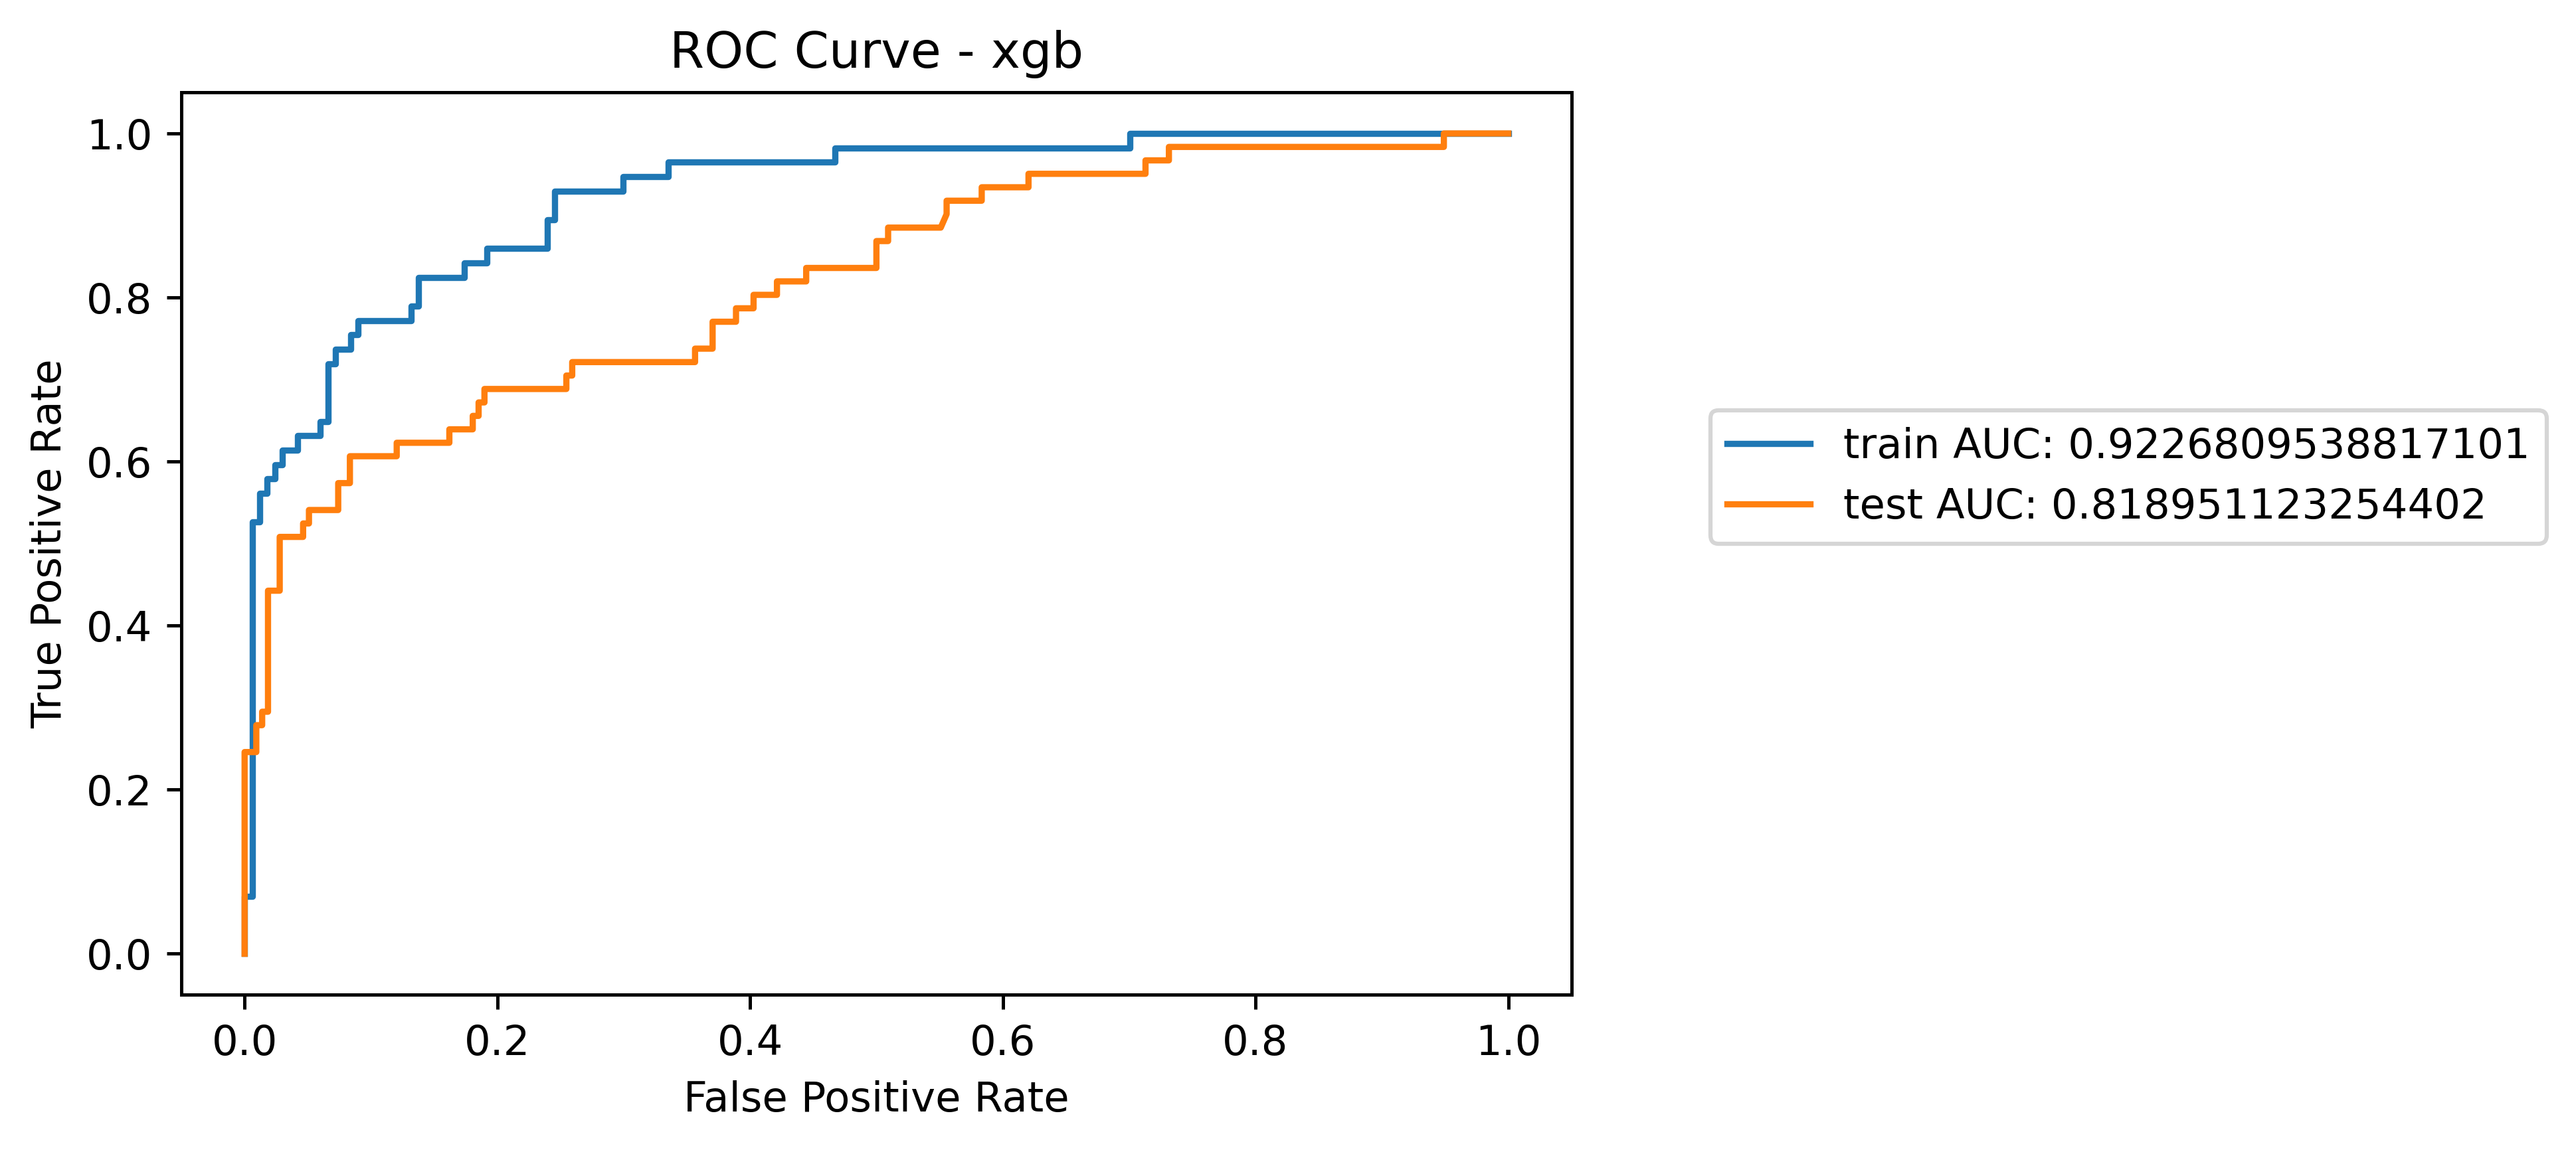

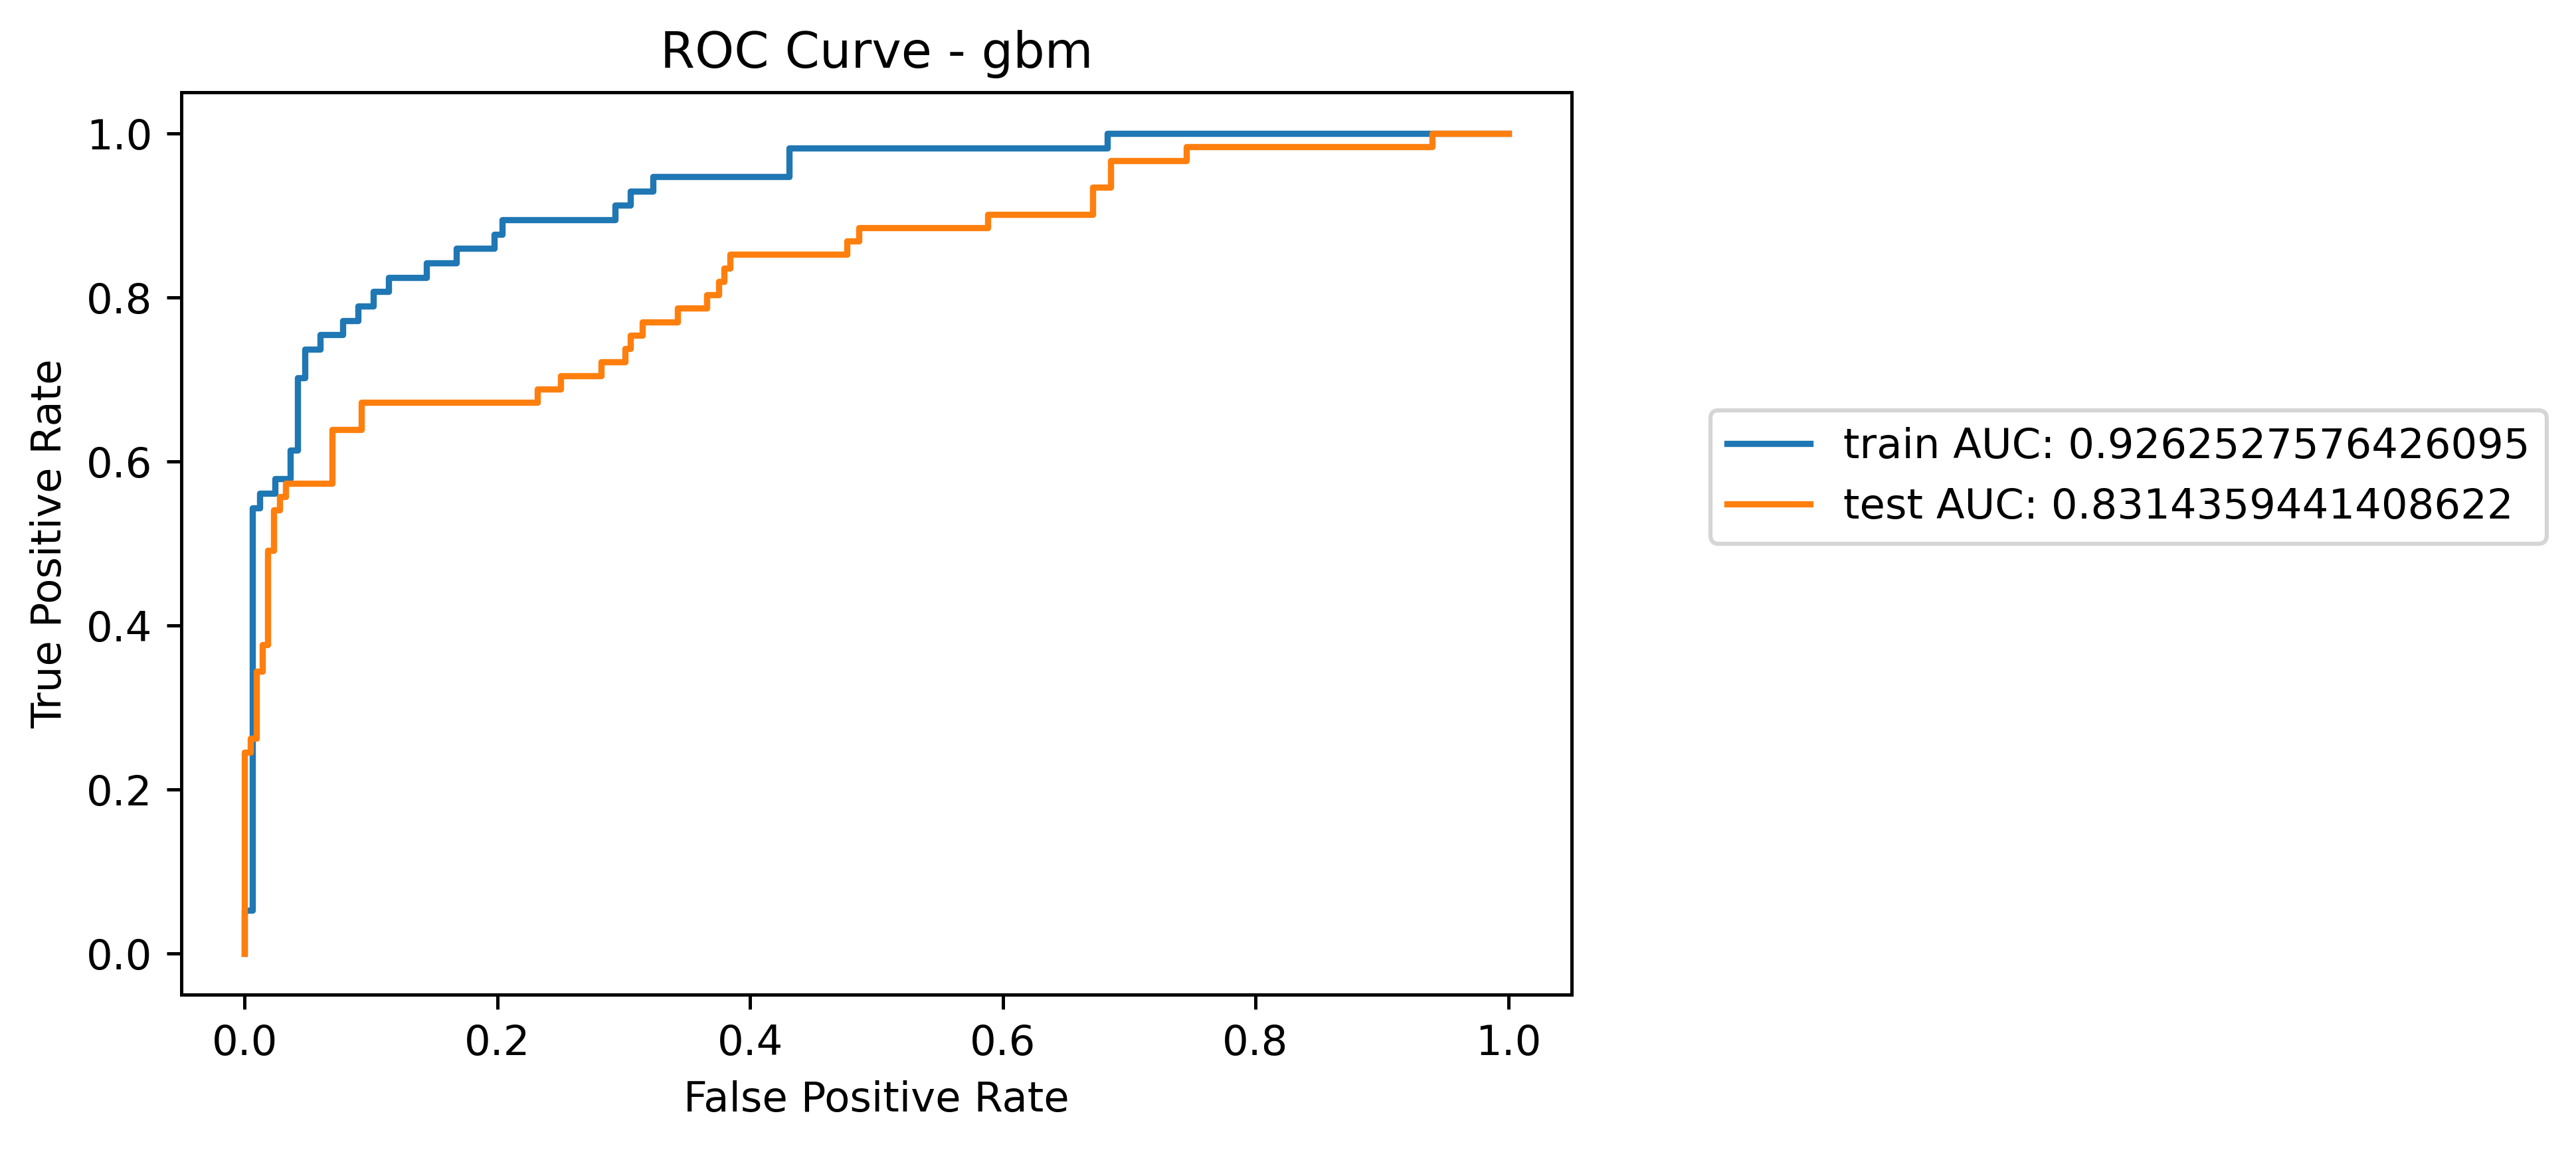

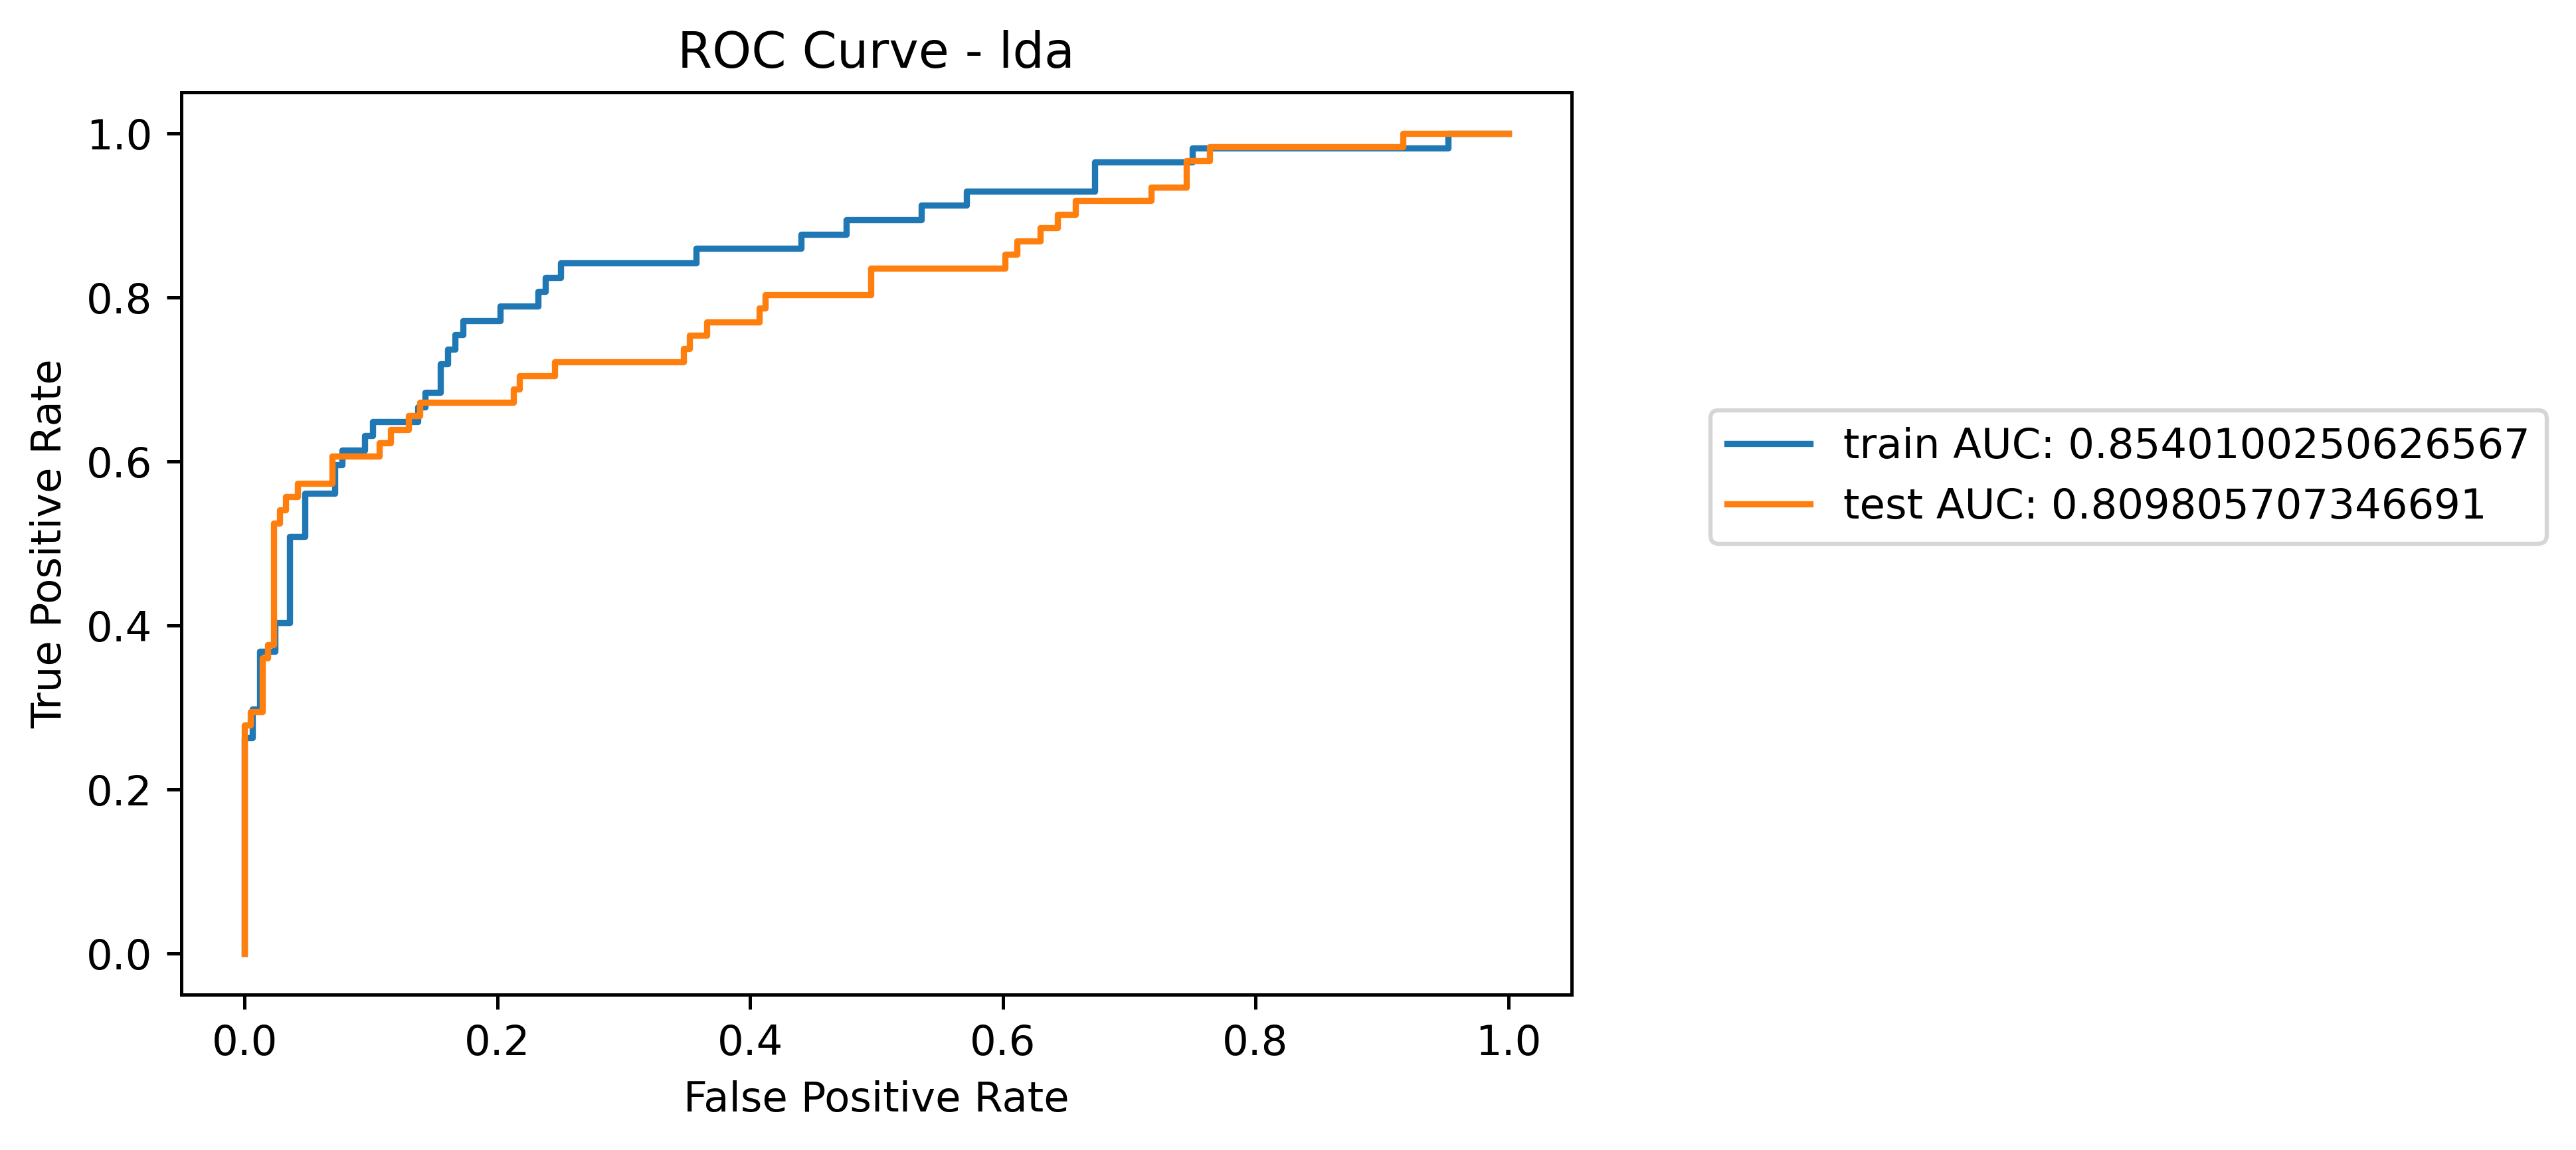

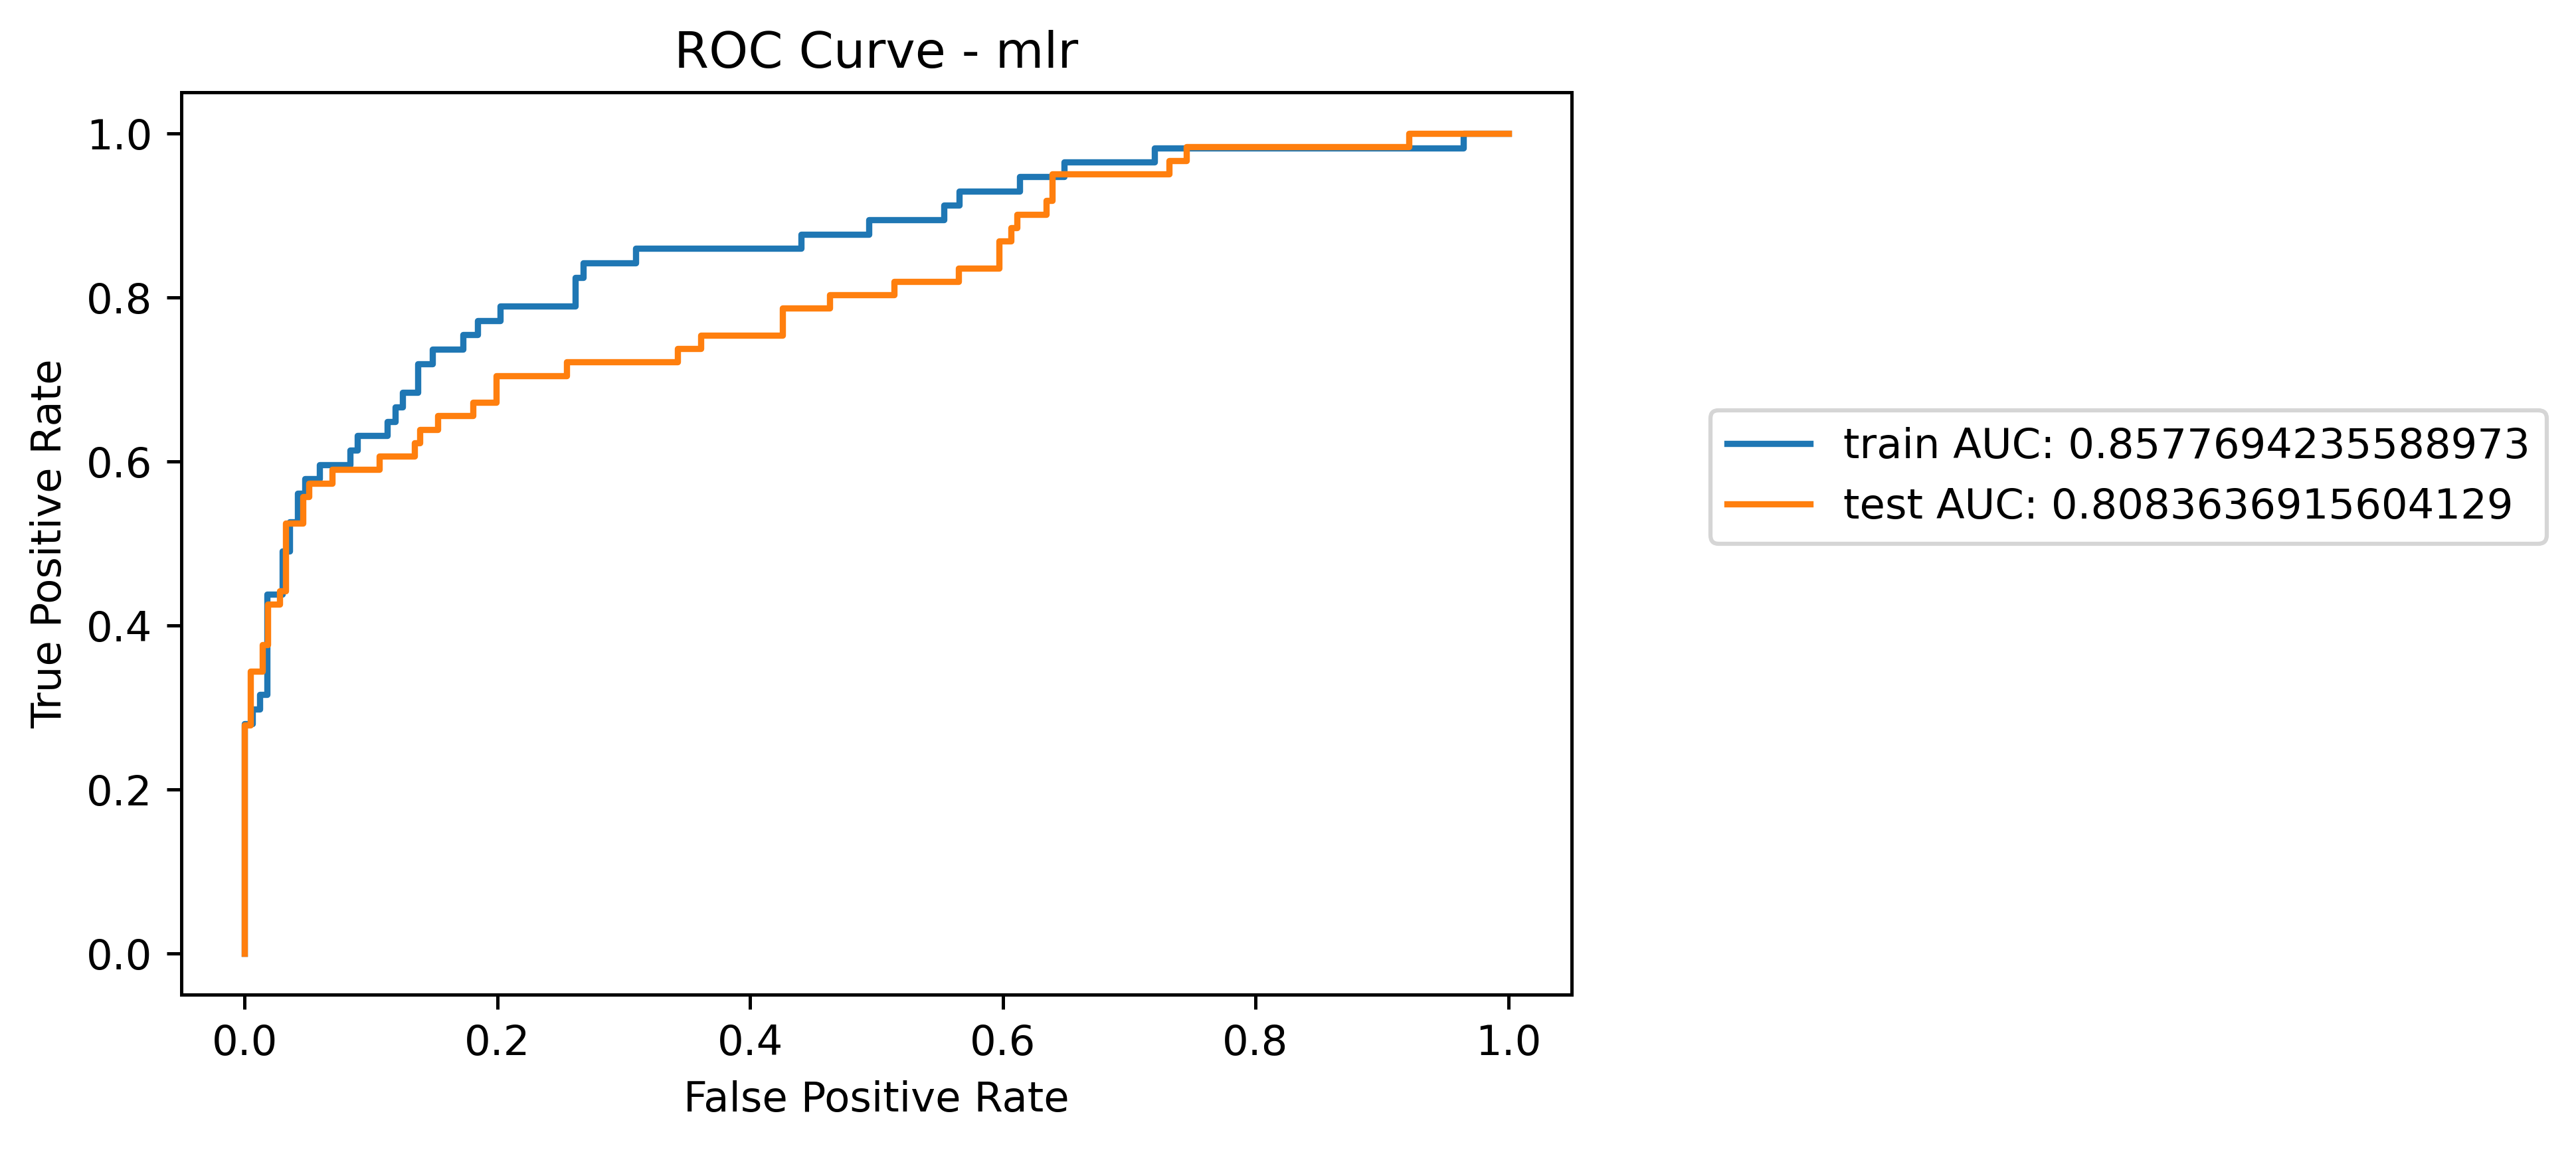

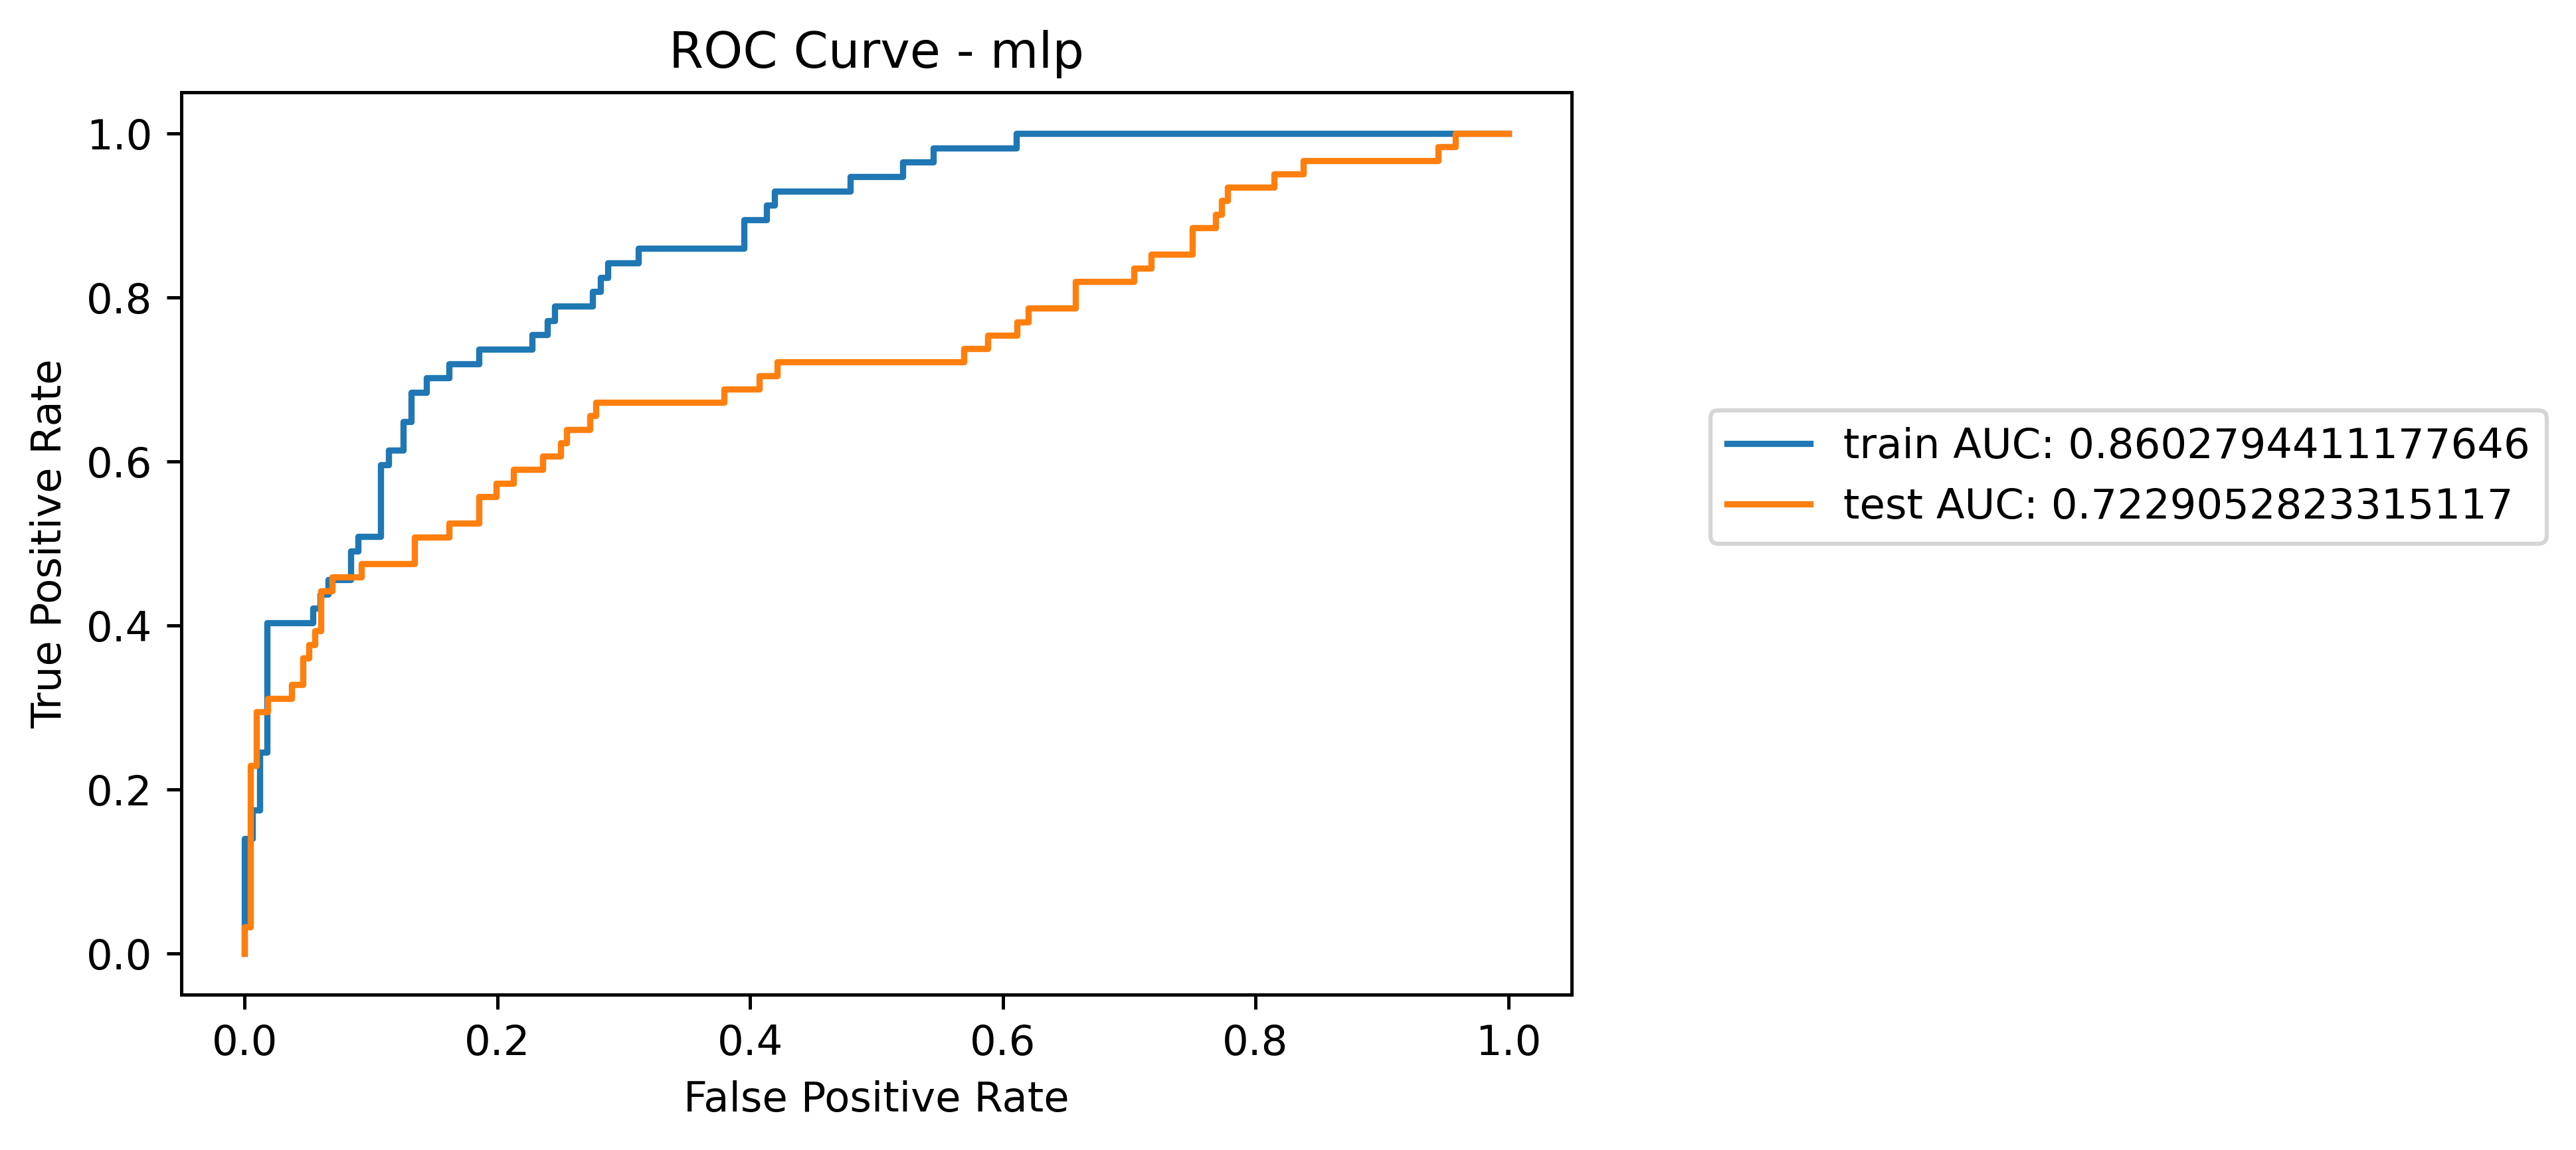

In [112]:
    # 繪製ROC曲線
    plt.figure(dpi=450)
    plt.plot(xgb_fpr_test, xgb_tpr_test, label="train AUC: "+str(xgb_auc_test))
    plt.plot(xgb_fpr_last_test, xgb_tpr_last_test, label="test AUC: "+str(xgb_auc_last_test))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - xgb')
    plt.legend(loc = (1.1,0.5))
    plt.show()

    # 繪製ROC曲線
    plt.figure(dpi=450)
    plt.plot(gbm_fpr_test, gbm_tpr_test, label="train AUC: "+str(gbm_auc_test))
    plt.plot(gbm_fpr_last_test, gbm_tpr_last_test, label="test AUC: "+str(gbm_auc_last_test))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - gbm')
    plt.legend(loc = (1.1,0.5))
    plt.show()

    # 繪製ROC曲線
    plt.figure(dpi=450)
    plt.plot(lda_fpr_test, lda_tpr_test, label="train AUC: "+str(lda_auc_test))
    plt.plot(lda_fpr_last_test, lda_tpr_last_test, label="test AUC: "+str(lda_auc_last_test))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - lda')
    plt.legend(loc = (1.1,0.5))
    plt.show()

    # 繪製ROC曲線
    plt.figure(dpi=450)
    plt.plot(mlr_fpr_test, mlr_tpr_test, label="train AUC: "+str(mlr_auc_test))
    plt.plot(mlr_fpr_last_test, mlr_tpr_last_test, label="test AUC: "+str(mlr_auc_last_test))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - mlr')
    plt.legend(loc = (1.1,0.5))
    plt.show()

    # 繪製ROC曲線
    plt.figure(dpi=450)
    plt.plot(mlp_fpr_test, mlp_tpr_test, label="train AUC: "+str(mlp_auc_test))
    plt.plot(mlp_fpr_last_test, mlp_tpr_last_test, label="test AUC: "+str(mlp_auc_last_test))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - mlp')
    plt.legend(loc = (1.1,0.5))
    plt.show()